

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_image_count =  int(qbz95.utils.get_notebook_name().split('.')[0].split('_')[3])

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*10/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120},
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':80}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2022-08-09 12:39:04,582: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json


### 下载数据

开始下载数据。

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [6]:
_, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(10000, 32, 32, 3) (10000,)
(10000, 32, 32, 3) (10000,)


In [7]:
Counter(train_labels)

Counter({7: 994,
         8: 1017,
         0: 973,
         6: 996,
         1: 979,
         5: 1015,
         2: 1030,
         4: 933,
         3: 1023,
         9: 1040})



### 查看数据

下面看一看实际的数据是啥样的。

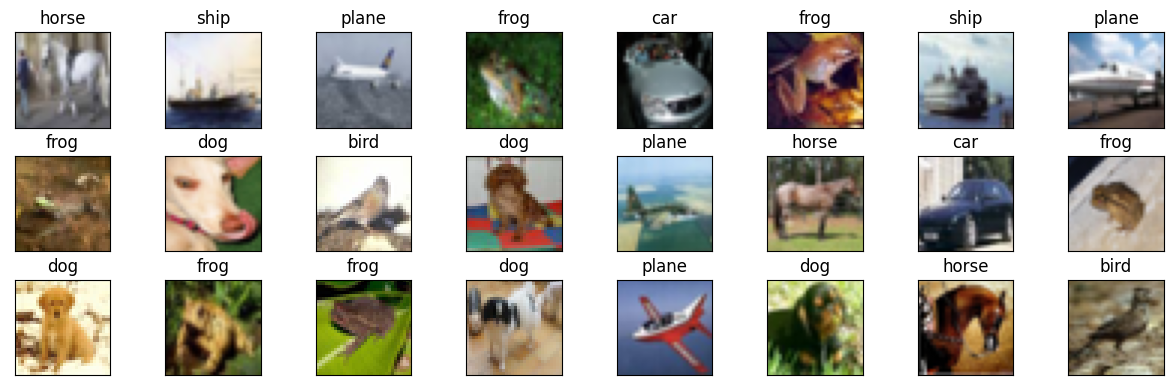

In [8]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

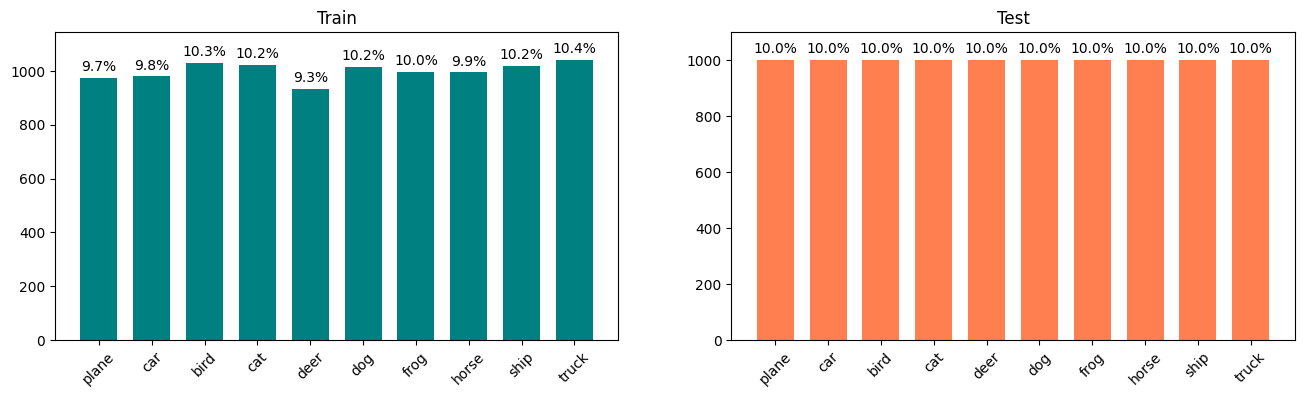

In [9]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [10]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [11]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [12]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

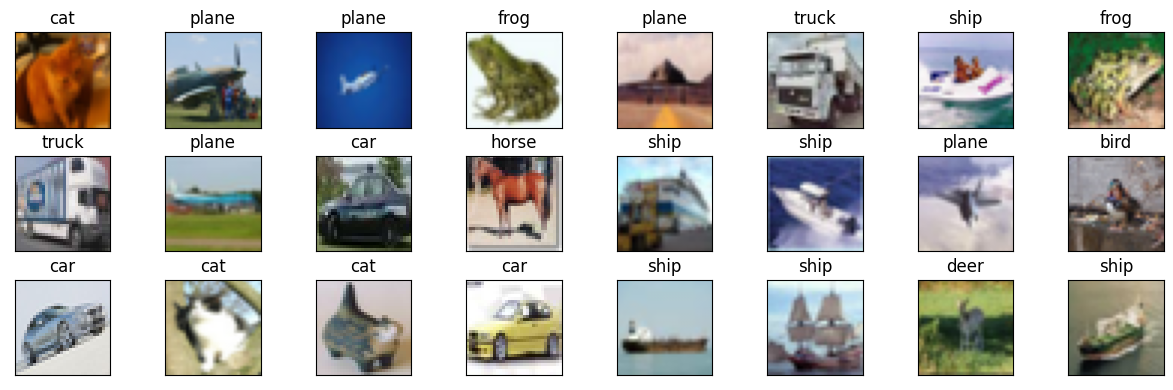

In [13]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [14]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

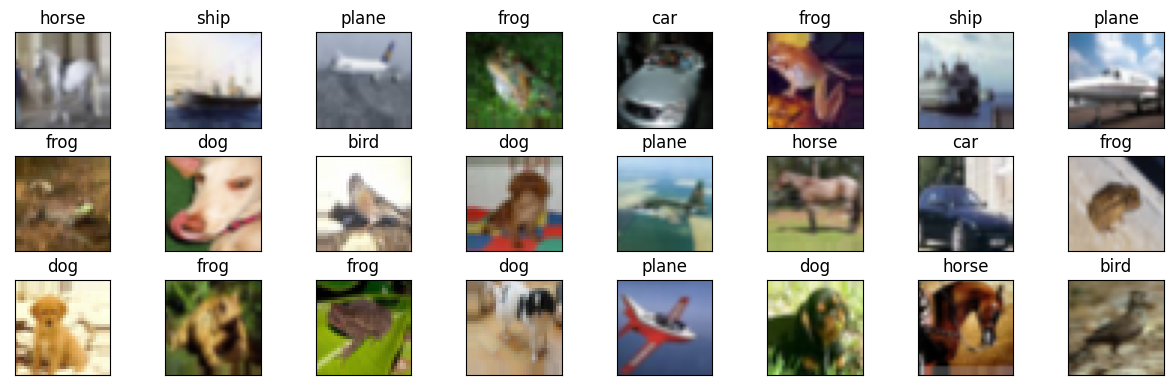

In [15]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

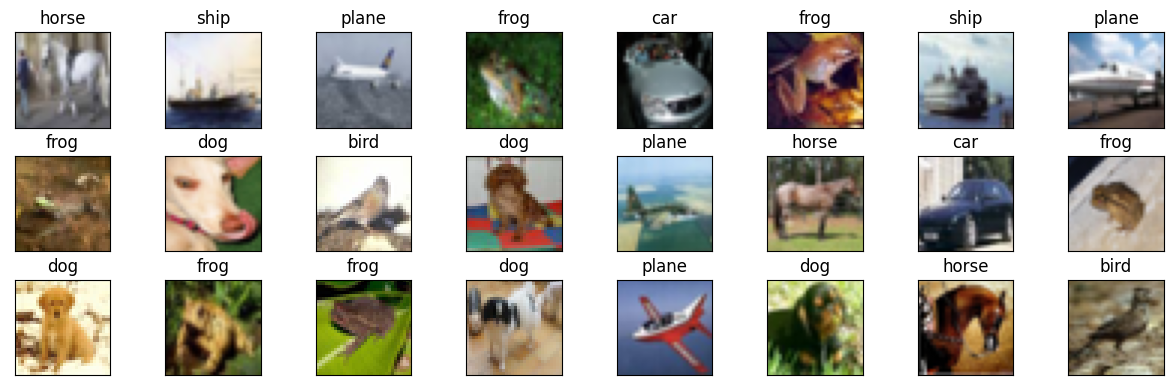

In [16]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [17]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [18]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


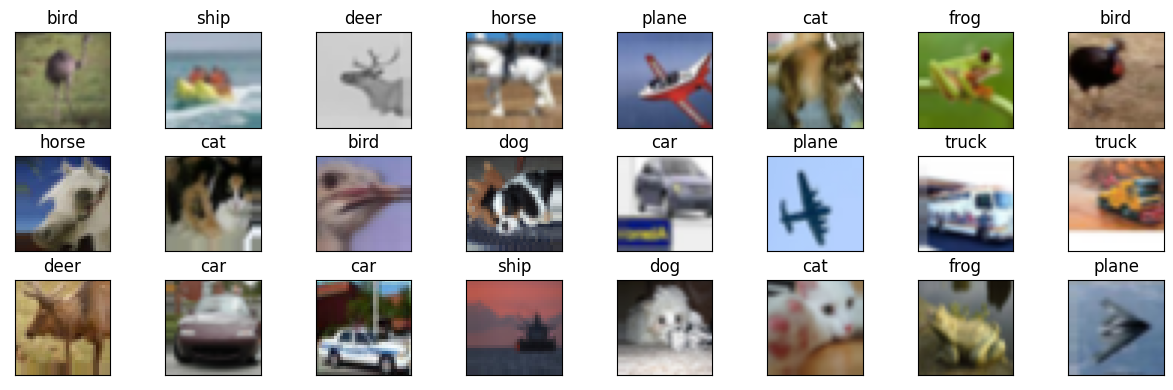

In [19]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2022-08-09 12:39:20,088: INFO: model_params.mlp1.dropout=0.1
2022-08-09 12:39:20,089: INFO: model_params.mlp1.layer_count=1
2022-08-09 12:39:20,090: INFO: model_params.mlp1.units=128
2022-08-09 12:39:20,132: INFO: learning_rate=0.001
2022-08-09 12:39:20,133: INFO: model_params.mlp1.clip_value=None
2022-08-09 12:39:20,142: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
___________________________________________________________

2022-08-09 12:39:20,154: INFO: model_params.mlp1.epochs=120
2022-08-09 12:39:20,154: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1, monitor=val_accuracy)
2022-08-09 12:39:20,155: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:39:20,156: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:39:20,156: INFO: use LearningRateScheduler()
2022-08-09 12:39:20,157: INFO: steps_per_epoch=312
2022-08-09 12:39:20,158: INFO: start training
2022-08-09 12:39:20,158: INFO: use_class_weight=False


Epoch 1/120
294/312 [===========================>..] - ETA: 0s - loss: 2.1185 - accuracy: 0.2251INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:23,145: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 3s 7ms/step - loss: 2.1116 - accuracy: 0.2269 - val_loss: 1.9879 - val_accuracy: 0.2466 - lr: 0.0010
Epoch 2/120
297/312 [===========================>..] - ETA: 0s - loss: 1.9194 - accuracy: 0.3010INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:25,198: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 7ms/step - loss: 1.9182 - accuracy: 0.3018 - val_loss: 1.8623 - val_accuracy: 0.3232 - lr: 0.0010
Epoch 3/120
312/312 [==============================] - 2s 7ms/step - loss: 1.8706 - accuracy: 0.3210 - val_loss: 1.8579 - val_accuracy: 0.3219 - lr: 0.0010
Epoch 4/120
300/312 [===========================>..] - ETA: 0s - loss: 1.8421 - accuracy: 0.3233INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:29,116: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.8426 - accuracy: 0.3226 - val_loss: 1.8049 - val_accuracy: 0.3532 - lr: 0.0010
Epoch 5/120
298/312 [===========================>..] - ETA: 0s - loss: 1.8179 - accuracy: 0.3374INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:31,002: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.8183 - accuracy: 0.3362 - val_loss: 1.7998 - val_accuracy: 0.3551 - lr: 0.0010
Epoch 6/120
312/312 [==============================] - 3s 9ms/step - loss: 1.8000 - accuracy: 0.3422 - val_loss: 1.8027 - val_accuracy: 0.3455 - lr: 0.0010
Epoch 7/120
312/312 [==============================] - 2s 7ms/step - loss: 1.7919 - accuracy: 0.3424 - val_loss: 1.7775 - val_accuracy: 0.3532 - lr: 0.0010
Epoch 8/120
307/312 [============================>.] - ETA: 0s - loss: 1.7772 - accuracy: 0.3526INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:38,691: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 3s 9ms/step - loss: 1.7775 - accuracy: 0.3525 - val_loss: 1.7751 - val_accuracy: 0.3621 - lr: 0.0010
Epoch 9/120
308/312 [============================>.] - ETA: 0s - loss: 1.7629 - accuracy: 0.3583INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:41,607: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 3s 9ms/step - loss: 1.7639 - accuracy: 0.3580 - val_loss: 1.7692 - val_accuracy: 0.3655 - lr: 0.0010
Epoch 10/120
302/312 [============================>.] - ETA: 0s - loss: 1.7588 - accuracy: 0.3574INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:43,974: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 8ms/step - loss: 1.7576 - accuracy: 0.3579 - val_loss: 1.7673 - val_accuracy: 0.3666 - lr: 0.0010
Epoch 11/120
293/312 [===========================>..] - ETA: 0s - loss: 1.7530 - accuracy: 0.3593INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:46,021: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 7ms/step - loss: 1.7547 - accuracy: 0.3586 - val_loss: 1.7651 - val_accuracy: 0.3735 - lr: 0.0010
Epoch 12/120
312/312 [==============================] - 2s 8ms/step - loss: 1.7392 - accuracy: 0.3652 - val_loss: 1.7665 - val_accuracy: 0.3678 - lr: 0.0010
Epoch 13/120
305/312 [============================>.] - ETA: 0s - loss: 1.7287 - accuracy: 0.3700INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:51,199: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 3s 9ms/step - loss: 1.7279 - accuracy: 0.3705 - val_loss: 1.7472 - val_accuracy: 0.3774 - lr: 0.0010
Epoch 14/120
306/312 [============================>.] - ETA: 0s - loss: 1.7176 - accuracy: 0.3804INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:39:53,982: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 3s 9ms/step - loss: 1.7172 - accuracy: 0.3804 - val_loss: 1.7365 - val_accuracy: 0.3802 - lr: 0.0010
Epoch 15/120
312/312 [==============================] - 2s 7ms/step - loss: 1.7132 - accuracy: 0.3824 - val_loss: 1.7680 - val_accuracy: 0.3613 - lr: 0.0010
Epoch 16/120
312/312 [==============================] - 2s 7ms/step - loss: 1.7037 - accuracy: 0.3824 - val_loss: 1.7648 - val_accuracy: 0.3687 - lr: 0.0010
Epoch 17/120
312/312 [==============================] - 1s 4ms/step - loss: 1.6951 - accuracy: 0.3857 - val_loss: 1.7610 - val_accuracy: 0.3702 - lr: 0.0010
Epoch 18/120
309/312 [============================>.] - ETA: 0s - loss: 1.6920 - accuracy: 0.3879INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:40:01,792: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 7ms/step - loss: 1.6926 - accuracy: 0.3875 - val_loss: 1.7335 - val_accuracy: 0.3851 - lr: 0.0010
Epoch 19/120
312/312 [==============================] - 2s 5ms/step - loss: 1.6979 - accuracy: 0.3848 - val_loss: 1.7644 - val_accuracy: 0.3643 - lr: 0.0010
Epoch 20/120
312/312 [==============================] - 2s 7ms/step - loss: 1.6802 - accuracy: 0.3898 - val_loss: 1.7619 - val_accuracy: 0.3671 - lr: 0.0010
Epoch 21/120
312/312 [==============================] - 2s 7ms/step - loss: 1.6744 - accuracy: 0.3882 - val_loss: 1.7327 - val_accuracy: 0.3811 - lr: 0.0010
Epoch 22/120
300/312 [===========================>..] - ETA: 0s - loss: 1.6713 - accuracy: 0.3893INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:40:09,952: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 8ms/step - loss: 1.6695 - accuracy: 0.3899 - val_loss: 1.7141 - val_accuracy: 0.3891 - lr: 0.0010
Epoch 23/120
312/312 [==============================] - 1s 4ms/step - loss: 1.6646 - accuracy: 0.3956 - val_loss: 1.7310 - val_accuracy: 0.3800 - lr: 0.0010
Epoch 24/120
300/312 [===========================>..] - ETA: 0s - loss: 1.6682 - accuracy: 0.3982INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:40:13,108: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.6663 - accuracy: 0.3986 - val_loss: 1.7155 - val_accuracy: 0.3906 - lr: 0.0010
Epoch 25/120
312/312 [==============================] - 3s 8ms/step - loss: 1.6554 - accuracy: 0.3949 - val_loss: 1.7617 - val_accuracy: 0.3679 - lr: 0.0010
Epoch 26/120
312/312 [==============================] - 1s 4ms/step - loss: 1.6567 - accuracy: 0.3998 - val_loss: 1.7173 - val_accuracy: 0.3906 - lr: 0.0010
Epoch 27/120
312/312 [==============================] - 1s 4ms/step - loss: 1.6537 - accuracy: 0.4002 - val_loss: 1.7119 - val_accuracy: 0.3905 - lr: 0.0010
Epoch 28/120
312/312 [==============================] - 1s 4ms/step - loss: 1.6440 - accuracy: 0.4008 - val_loss: 1.7614 - val_accuracy: 0.3702 - lr: 0.0010
Epoch 29/120
312/312 [==============================] - 2s 6ms/step - loss: 1.6434 - accuracy: 0.4039 - val_loss: 1.7486 - val_accuracy: 0.3761 - lr: 0.0010
Epoch 30/120
312/312 [==============================] - 2s 7ms/step - l

2022-08-09 12:40:28,904: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 3s 9ms/step - loss: 1.6278 - accuracy: 0.4053 - val_loss: 1.7123 - val_accuracy: 0.3928 - lr: 0.0010
Epoch 33/120
312/312 [==============================] - 1s 4ms/step - loss: 1.6286 - accuracy: 0.4094 - val_loss: 1.7355 - val_accuracy: 0.3812 - lr: 0.0010
Epoch 34/120
312/312 [==============================] - 1s 4ms/step - loss: 1.6122 - accuracy: 0.4154 - val_loss: 1.7641 - val_accuracy: 0.3768 - lr: 0.0010
Epoch 35/120
312/312 [==============================] - 1s 4ms/step - loss: 1.6203 - accuracy: 0.4123 - val_loss: 1.7361 - val_accuracy: 0.3805 - lr: 0.0010
Epoch 36/120
312/312 [==============================] - 2s 7ms/step - loss: 1.6074 - accuracy: 0.4121 - val_loss: 1.7492 - val_accuracy: 0.3821 - lr: 0.0010
Epoch 37/120
312/312 [==============================] - 2s 5ms/step - loss: 1.6222 - accuracy: 0.4020 - val_loss: 1.7450 - val_accuracy: 0.3799 - lr: 0.0010
Epoch 38/120
312/312 [==============================] - 1s 4ms/step - l

2022-08-09 12:41:12,134: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 7ms/step - loss: 1.5189 - accuracy: 0.4426 - val_loss: 1.7162 - val_accuracy: 0.3949 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/120
312/312 [==============================] - 2s 7ms/step - loss: 1.5190 - accuracy: 0.4463 - val_loss: 1.7195 - val_accuracy: 0.3946 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/120
301/312 [===========================>..] - ETA: 0s - loss: 1.5195 - accuracy: 0.4466INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:41:17,375: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 3s 10ms/step - loss: 1.5189 - accuracy: 0.4453 - val_loss: 1.7158 - val_accuracy: 0.3960 - lr: 1.0000e-04
Epoch 61/120
302/312 [============================>.] - ETA: 0s - loss: 1.5209 - accuracy: 0.4415INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:41:19,284: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.5199 - accuracy: 0.4417 - val_loss: 1.7164 - val_accuracy: 0.3962 - lr: 1.0000e-04
Epoch 62/120
296/312 [===========================>..] - ETA: 0s - loss: 1.5093 - accuracy: 0.4455INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:41:21,164: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.5101 - accuracy: 0.4456 - val_loss: 1.7169 - val_accuracy: 0.3970 - lr: 1.0000e-04
Epoch 63/120
312/312 [==============================] - 3s 8ms/step - loss: 1.5254 - accuracy: 0.4399 - val_loss: 1.7195 - val_accuracy: 0.3944 - lr: 1.0000e-04
Epoch 64/120
312/312 [==============================] - 2s 6ms/step - loss: 1.5118 - accuracy: 0.4430 - val_loss: 1.7136 - val_accuracy: 0.3949 - lr: 1.0000e-04
Epoch 65/120
307/312 [============================>.] - ETA: 0s - loss: 1.5172 - accuracy: 0.4465INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


2022-08-09 12:41:27,489: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1/assets


312/312 [==============================] - 2s 6ms/step - loss: 1.5175 - accuracy: 0.4454 - val_loss: 1.7135 - val_accuracy: 0.3977 - lr: 1.0000e-04
Epoch 66/120
312/312 [==============================] - 2s 5ms/step - loss: 1.5191 - accuracy: 0.4486 - val_loss: 1.7196 - val_accuracy: 0.3941 - lr: 1.0000e-04
Epoch 67/120
312/312 [==============================] - 2s 8ms/step - loss: 1.5132 - accuracy: 0.4496 - val_loss: 1.7165 - val_accuracy: 0.3968 - lr: 1.0000e-04
Epoch 68/120
312/312 [==============================] - 2s 7ms/step - loss: 1.5146 - accuracy: 0.4510 - val_loss: 1.7171 - val_accuracy: 0.3971 - lr: 1.0000e-04
Epoch 69/120
312/312 [==============================] - 2s 6ms/step - loss: 1.5097 - accuracy: 0.4434 - val_loss: 1.7221 - val_accuracy: 0.3928 - lr: 1.0000e-04
Epoch 70/120
312/312 [==============================] - 1s 4ms/step - loss: 1.5074 - accuracy: 0.4505 - val_loss: 1.7190 - val_accuracy: 0.3959 - lr: 1.0000e-04
Epoch 71/120
312/312 [=========================

Epoch 00105: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 105/120
312/312 [==============================] - 1s 4ms/step - loss: 1.4980 - accuracy: 0.4508 - val_loss: 1.7158 - val_accuracy: 0.3966 - lr: 3.1623e-06
Epoch 105: early stopping


2022-08-09 12:42:37,489: INFO: finish training [elapsed time: 197.33 seconds]


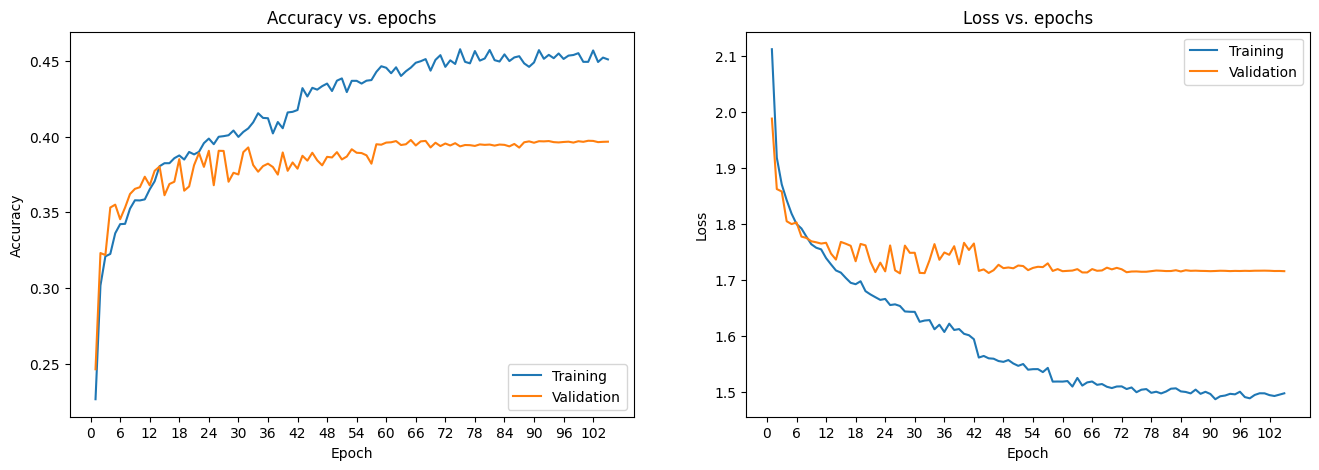

2022-08-09 12:42:37,902: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 12:42:45,438: INFO: test loss:1.7135
2022-08-09 12:42:45,439: INFO: test accuracy:0.3977
2022-08-09 12:42:45,440: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 12:42:45,442: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 12:42:45,443: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:42:45,445: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:42:45,446: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:42:50,569: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator


313/313 [==============================] - 4s 6ms/step


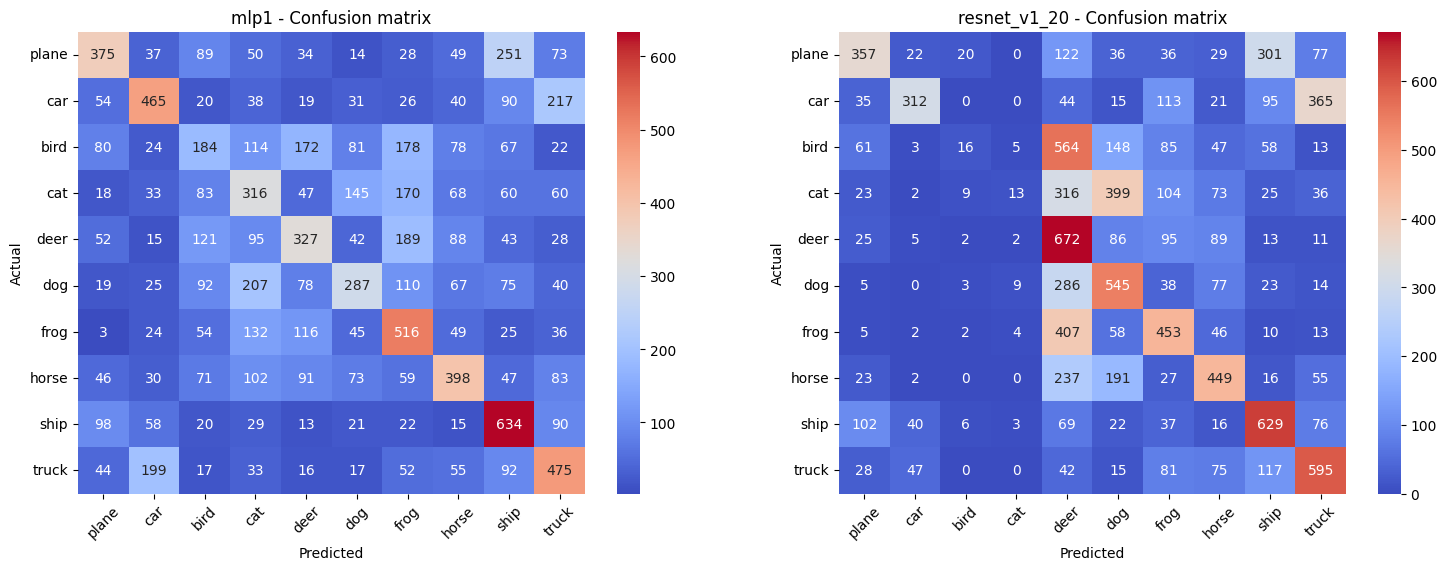

2022-08-09 12:42:57,877: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:43:02,538: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:43:02,544: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1
2022-08-09 12:43:03,373: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:43:03,376: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1
2022-08-09 12:43:04,369: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:43:04,372: INFO: loading model from /tf/eipi10/xuxiangwen.gi

1/1 [==============================] - 0s 147ms/step


2022-08-09 12:43:08,774: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f2fbc784280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 14ms/step


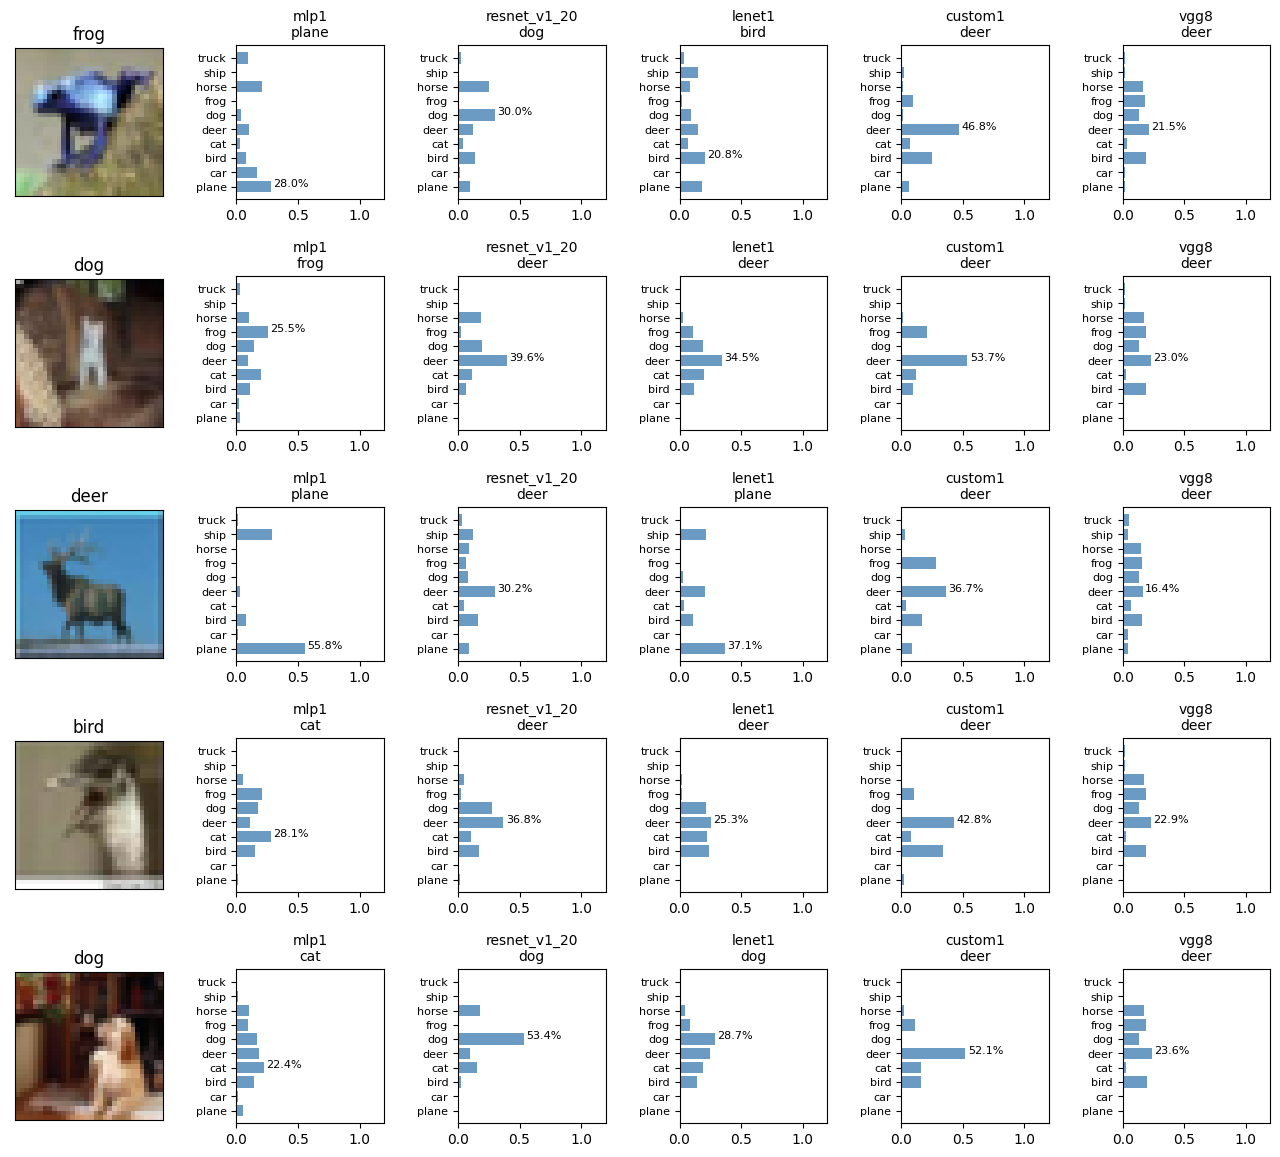

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1  resnet_v1_20  cifar10_0808_count_1000.ipynb         273066        21.6   
2          mlp1  cifar10_0808_count_1000.ipynb         394634       197.3   
3        lenet1  cifar10_0808_count_1000.ipynb          83170         5.4   
4       custom1  cifar10_0808_count_1000.ipynb          73738         5.6   
5          vgg8  cifar10_0808_count_1000.ipynb        1672906        11.1   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 05:45      1.6813     1.7428          0.4237         0.4041   
2  2022-08-09 12:42      1.4287     1.7135          0.4881         0.3977   
3  2022-08-09 05:43      1.9472     1.9526          0.2903         0.2901   
4  2022-08-09 05:43      2.8900     2.8886          0.1774         0.1772   
5  2022-08-09 05:44      2.7276     2.7176          0.0936         0.1002   

   train_auc  test_auc  
1     0.8770    0.8637  
2     0.8814    0.8221  
3     0.8004    0.7968  
4     0.7707    0.7660  
5     0.6417    0.6417

In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2022-08-09 12:43:13,085: INFO: model_params.lenet1.dropout=0.2
2022-08-09 12:43:13,173: INFO: learning_rate=0.001
2022-08-09 12:43:13,174: INFO: model_params.lenet1.clip_value=None
2022-08-09 12:43:13,181: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0         
                                                               

2022-08-09 12:43:13,218: INFO: model_params.lenet1.epochs=120
2022-08-09 12:43:13,219: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1, monitor=val_accuracy)
2022-08-09 12:43:13,220: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:43:13,221: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:43:13,222: INFO: use LearningRateScheduler()
2022-08-09 12:43:13,223: INFO: steps_per_epoch=312
2022-08-09 12:43:13,224: INFO: start training
2022-08-09 12:43:13,225: INFO: use_class_weight=False


Epoch 1/120
302/312 [============================>.] - ETA: 0s - loss: 2.0931 - accuracy: 0.2497

2022-08-09 12:43:17,772: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:43:18,418: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 14ms/step - loss: 2.0878 - accuracy: 0.2508 - val_loss: 1.9949 - val_accuracy: 0.2699 - lr: 0.0010
Epoch 2/120
307/312 [============================>.] - ETA: 0s - loss: 1.7870 - accuracy: 0.3523

2022-08-09 12:43:23,312: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:43:23,928: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 18ms/step - loss: 1.7853 - accuracy: 0.3517 - val_loss: 1.6402 - val_accuracy: 0.4087 - lr: 0.0010
Epoch 3/120
312/312 [==============================] - 4s 12ms/step - loss: 1.6523 - accuracy: 0.3941 - val_loss: 1.7067 - val_accuracy: 0.3863 - lr: 0.0010
Epoch 4/120
306/312 [============================>.] - ETA: 0s - loss: 1.5528 - accuracy: 0.4343

2022-08-09 12:43:31,216: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:43:31,827: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 1.5546 - accuracy: 0.4331 - val_loss: 1.4823 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 5/120
312/312 [==============================] - 4s 12ms/step - loss: 1.4815 - accuracy: 0.4648 - val_loss: 1.5769 - val_accuracy: 0.4352 - lr: 0.0010
Epoch 6/120
312/312 [==============================] - 4s 12ms/step - loss: 1.4265 - accuracy: 0.4803 - val_loss: 1.8194 - val_accuracy: 0.3840 - lr: 0.0010
Epoch 7/120
309/312 [============================>.] - ETA: 0s - loss: 1.3614 - accuracy: 0.5097

2022-08-09 12:43:45,039: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:43:45,662: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 6s 21ms/step - loss: 1.3634 - accuracy: 0.5087 - val_loss: 1.3472 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 8/120
312/312 [==============================] - 2s 8ms/step - loss: 1.3033 - accuracy: 0.5271 - val_loss: 1.4675 - val_accuracy: 0.4757 - lr: 0.0010
Epoch 9/120
308/312 [============================>.] - ETA: 0s - loss: 1.2719 - accuracy: 0.5405

2022-08-09 12:43:51,587: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:43:52,183: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 1.2737 - accuracy: 0.5397 - val_loss: 1.3252 - val_accuracy: 0.5158 - lr: 0.0010
Epoch 10/120
312/312 [==============================] - ETA: 0s - loss: 1.2266 - accuracy: 0.5617

2022-08-09 12:43:56,891: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:43:57,500: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 17ms/step - loss: 1.2266 - accuracy: 0.5617 - val_loss: 1.3380 - val_accuracy: 0.5197 - lr: 0.0010
Epoch 11/120
312/312 [==============================] - 3s 10ms/step - loss: 1.2100 - accuracy: 0.5595 - val_loss: 1.4554 - val_accuracy: 0.4902 - lr: 0.0010
Epoch 12/120
308/312 [============================>.] - ETA: 0s - loss: 1.1712 - accuracy: 0.5767

2022-08-09 12:44:05,148: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:44:05,742: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 16ms/step - loss: 1.1732 - accuracy: 0.5763 - val_loss: 1.2718 - val_accuracy: 0.5388 - lr: 0.0010
Epoch 13/120
312/312 [==============================] - 3s 9ms/step - loss: 1.1439 - accuracy: 0.5845 - val_loss: 1.4166 - val_accuracy: 0.5141 - lr: 0.0010
Epoch 14/120
312/312 [==============================] - 3s 8ms/step - loss: 1.1189 - accuracy: 0.6008 - val_loss: 1.3201 - val_accuracy: 0.5384 - lr: 0.0010
Epoch 15/120
309/312 [============================>.] - ETA: 0s - loss: 1.0886 - accuracy: 0.6064

2022-08-09 12:44:14,576: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:44:15,165: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 1.0899 - accuracy: 0.6064 - val_loss: 1.3192 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 16/120
307/312 [============================>.] - ETA: 0s - loss: 1.0716 - accuracy: 0.6176

2022-08-09 12:44:19,799: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:44:20,422: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 17ms/step - loss: 1.0720 - accuracy: 0.6170 - val_loss: 1.3071 - val_accuracy: 0.5513 - lr: 0.0010
Epoch 17/120
310/312 [============================>.] - ETA: 0s - loss: 1.0554 - accuracy: 0.6200

2022-08-09 12:44:24,597: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:44:25,210: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 15ms/step - loss: 1.0558 - accuracy: 0.6200 - val_loss: 1.2381 - val_accuracy: 0.5673 - lr: 0.0010
Epoch 18/120
312/312 [==============================] - 2s 7ms/step - loss: 1.0160 - accuracy: 0.6324 - val_loss: 1.2827 - val_accuracy: 0.5534 - lr: 0.0010
Epoch 19/120
312/312 [==============================] - 2s 7ms/step - loss: 1.0219 - accuracy: 0.6298 - val_loss: 1.2839 - val_accuracy: 0.5596 - lr: 0.0010
Epoch 20/120
312/312 [==============================] - 3s 10ms/step - loss: 0.9897 - accuracy: 0.6392 - val_loss: 1.2601 - val_accuracy: 0.5631 - lr: 0.0010
Epoch 21/120
312/312 [==============================] - 2s 6ms/step - loss: 0.9680 - accuracy: 0.6587 - val_loss: 1.2742 - val_accuracy: 0.5661 - lr: 0.0010
Epoch 22/120
312/312 [==============================] - 2s 7ms/step - loss: 0.9578 - accuracy: 0.6544 - val_loss: 1.2821 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 23/120
312/312 [==============================] - 4s 12ms/step 

2022-08-09 12:44:48,961: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:44:49,559: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 18ms/step - loss: 0.9214 - accuracy: 0.6702 - val_loss: 1.2699 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 26/120
312/312 [==============================] - 4s 11ms/step - loss: 0.9028 - accuracy: 0.6783 - val_loss: 1.3537 - val_accuracy: 0.5577 - lr: 0.0010
Epoch 27/120
312/312 [==============================] - 4s 11ms/step - loss: 0.8862 - accuracy: 0.6790 - val_loss: 1.3288 - val_accuracy: 0.5721 - lr: 0.0010
Epoch 28/120
312/312 [==============================] - 3s 11ms/step - loss: 0.8706 - accuracy: 0.6843 - val_loss: 1.3172 - val_accuracy: 0.5732 - lr: 0.0010
Epoch 29/120
309/312 [============================>.] - ETA: 0s - loss: 0.8759 - accuracy: 0.6843

2022-08-09 12:45:04,843: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:45:05,444: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 17ms/step - loss: 0.8746 - accuracy: 0.6844 - val_loss: 1.2976 - val_accuracy: 0.5779 - lr: 0.0010
Epoch 30/120
312/312 [==============================] - 2s 7ms/step - loss: 0.8648 - accuracy: 0.6879 - val_loss: 1.3922 - val_accuracy: 0.5630 - lr: 0.0010
Epoch 31/120
312/312 [==============================] - 3s 8ms/step - loss: 0.8403 - accuracy: 0.6928 - val_loss: 1.3948 - val_accuracy: 0.5649 - lr: 0.0010
Epoch 32/120
309/312 [============================>.] - ETA: 0s - loss: 0.8342 - accuracy: 0.6991
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
312/312 [==============================] - 3s 9ms/step - loss: 0.8364 - accuracy: 0.6990 - val_loss: 1.3646 - val_accuracy: 0.5747 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/120
312/312 [==============================] - 3s 9ms/step - loss: 0.7615 - accuracy: 0.7284 - val_loss: 1.4294 - val_accuracy: 0.5615 - lr: 3.

2022-08-09 12:45:20,145: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:45:20,744: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.7555 - accuracy: 0.7278 - val_loss: 1.2933 - val_accuracy: 0.5898 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/120
312/312 [==============================] - 2s 6ms/step - loss: 0.7468 - accuracy: 0.7300 - val_loss: 1.5666 - val_accuracy: 0.5414 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/120
312/312 [==============================] - 2s 6ms/step - loss: 0.7373 - accuracy: 0.7334 - val_loss: 1.4005 - val_accuracy: 0.5754 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/120
312/312 [==============================] - 2s 6ms/step - loss: 0.7236 - accuracy: 0.7398 - val_loss: 1.4348 - val_accuracy: 0.5739 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/120
312/312 [==============================] - 2s 7ms/step - loss: 0.7326 - accuracy: 0.7356 - val_

2022-08-09 12:45:52,479: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:45:53,071: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.6644 - accuracy: 0.7567 - val_loss: 1.2913 - val_accuracy: 0.5991 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/120
307/312 [============================>.] - ETA: 0s - loss: 0.6545 - accuracy: 0.7598

2022-08-09 12:45:56,360: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:45:56,955: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.6564 - accuracy: 0.7587 - val_loss: 1.2966 - val_accuracy: 0.6010 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/120
312/312 [==============================] - 2s 8ms/step - loss: 0.6373 - accuracy: 0.7627 - val_loss: 1.3085 - val_accuracy: 0.5975 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/120
312/312 [==============================] - 3s 8ms/step - loss: 0.6536 - accuracy: 0.7640 - val_loss: 1.3126 - val_accuracy: 0.5977 - lr: 1.0000e-04
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
Epoch 52/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6463 - accuracy: 0.7647 - val_loss: 1.2941 - val_accuracy: 0.5987 - lr: 1.0000e-04
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
Epoch 53/120
312/312 [==============================] - 2s 6ms/step - loss: 0.6399 - accuracy: 0.7660 - val_loss: 1.3190

2022-08-09 12:46:09,269: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:46:09,844: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 4s 12ms/step - loss: 0.6504 - accuracy: 0.7671 - val_loss: 1.3022 - val_accuracy: 0.6024 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/120
311/312 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.7639

2022-08-09 12:46:13,161: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:46:13,790: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 0.6458 - accuracy: 0.7640 - val_loss: 1.2846 - val_accuracy: 0.6037 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6536 - accuracy: 0.7666 - val_loss: 1.3199 - val_accuracy: 0.5965 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6394 - accuracy: 0.7688 - val_loss: 1.3226 - val_accuracy: 0.5973 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/120
312/312 [==============================] - 2s 6ms/step - loss: 0.6266 - accuracy: 0.7746 - val_loss: 1.2905 - val_accuracy: 0.6021 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6384 - accuracy: 0.7680 - val_loss: 1.3346

2022-08-09 12:46:32,481: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:46:33,512: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 16ms/step - loss: 0.6337 - accuracy: 0.7776 - val_loss: 1.2798 - val_accuracy: 0.6069 - lr: 3.1623e-05
Epoch 00064: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 64/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6108 - accuracy: 0.7805 - val_loss: 1.2826 - val_accuracy: 0.6040 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6194 - accuracy: 0.7738 - val_loss: 1.2961 - val_accuracy: 0.6047 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6285 - accuracy: 0.7728 - val_loss: 1.2853 - val_accuracy: 0.6057 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6120 - accuracy: 0.7782 - val_

2022-08-09 12:47:12,574: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:47:13,173: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.6141 - accuracy: 0.7774 - val_loss: 1.2900 - val_accuracy: 0.6072 - lr: 1.0000e-05
Epoch 00081: Still keep learning rate 1e-05 instead of 0.0001
Epoch 81/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6300 - accuracy: 0.7731 - val_loss: 1.2959 - val_accuracy: 0.6038 - lr: 1.0000e-05
Epoch 00082: Still keep learning rate 1e-05 instead of 0.0001
Epoch 82/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6153 - accuracy: 0.7775 - val_loss: 1.2869 - val_accuracy: 0.6070 - lr: 1.0000e-05
Epoch 00083: Still keep learning rate 1e-05 instead of 0.0001
Epoch 83/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6103 - accuracy: 0.7787 - val_loss: 1.2886 - val_accuracy: 0.6061 - lr: 1.0000e-05
Epoch 00084: Still keep learning rate 1e-05 instead of 0.0001
Epoch 84/120
312/312 [==============================] - 2s 7ms/step - loss: 0.6155 - accuracy: 0.7782 - val_loss: 1.2946

2022-08-09 12:47:33,625: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:47:34,208: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 0.6058 - accuracy: 0.7830 - val_loss: 1.2912 - val_accuracy: 0.6076 - lr: 1.0000e-05
Epoch 00090: Still keep learning rate 1e-05 instead of 0.0001
Epoch 90/120
312/312 [==============================] - 2s 6ms/step - loss: 0.6209 - accuracy: 0.7785 - val_loss: 1.2918 - val_accuracy: 0.6052 - lr: 1.0000e-05
Epoch 91/120
312/312 [==============================] - 2s 6ms/step - loss: 0.6090 - accuracy: 0.7808 - val_loss: 1.2924 - val_accuracy: 0.6061 - lr: 1.0000e-05
Epoch 92/120
302/312 [============================>.] - ETA: 0s - loss: 0.6146 - accuracy: 0.7740
Epoch 92: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
312/312 [==============================] - 2s 7ms/step - loss: 0.6160 - accuracy: 0.7737 - val_loss: 1.2910 - val_accuracy: 0.6068 - lr: 3.1623e-06
Epoch 00093: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 93/120
312/312 [==============================] - 2s 6ms/step - loss: 0.61

2022-08-09 12:48:28,454: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


2022-08-09 12:48:29,049: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1/assets


312/312 [==============================] - 4s 13ms/step - loss: 0.6085 - accuracy: 0.7809 - val_loss: 1.2903 - val_accuracy: 0.6077 - lr: 5.0000e-07
Epoch 00114: Still keep learning rate 5e-07 instead of 1e-06
Epoch 114/120
312/312 [==============================] - 2s 6ms/step - loss: 0.6131 - accuracy: 0.7792 - val_loss: 1.2899 - val_accuracy: 0.6071 - lr: 5.0000e-07
Epoch 00115: Still keep learning rate 5e-07 instead of 1e-06
Epoch 115/120
312/312 [==============================] - 2s 6ms/step - loss: 0.6048 - accuracy: 0.7833 - val_loss: 1.2900 - val_accuracy: 0.6071 - lr: 5.0000e-07
Epoch 00116: Still keep learning rate 5e-07 instead of 1e-06
Epoch 116/120
312/312 [==============================] - 2s 6ms/step - loss: 0.6073 - accuracy: 0.7815 - val_loss: 1.2904 - val_accuracy: 0.6071 - lr: 5.0000e-07
Epoch 00117: Still keep learning rate 5e-07 instead of 1e-06
Epoch 117/120
312/312 [==============================] - 2s 6ms/step - loss: 0.6115 - accuracy: 0.7782 - val_loss: 1.2902

2022-08-09 12:48:43,454: INFO: finish training [elapsed time: 330.23 seconds]


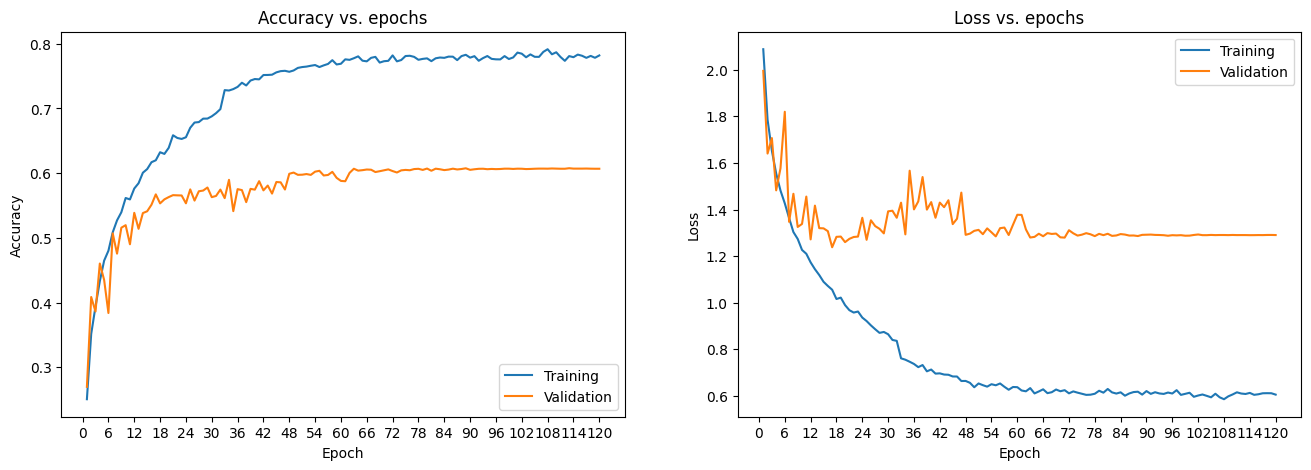

2022-08-09 12:48:43,908: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 12:48:51,321: INFO: test loss:1.2903
2022-08-09 12:48:51,322: INFO: test accuracy:0.6077
2022-08-09 12:48:51,324: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 12:48:51,326: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 12:48:51,327: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:48:51,329: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:48:51,330: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:48:56,118: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator


313/313 [==============================] - 2s 6ms/step


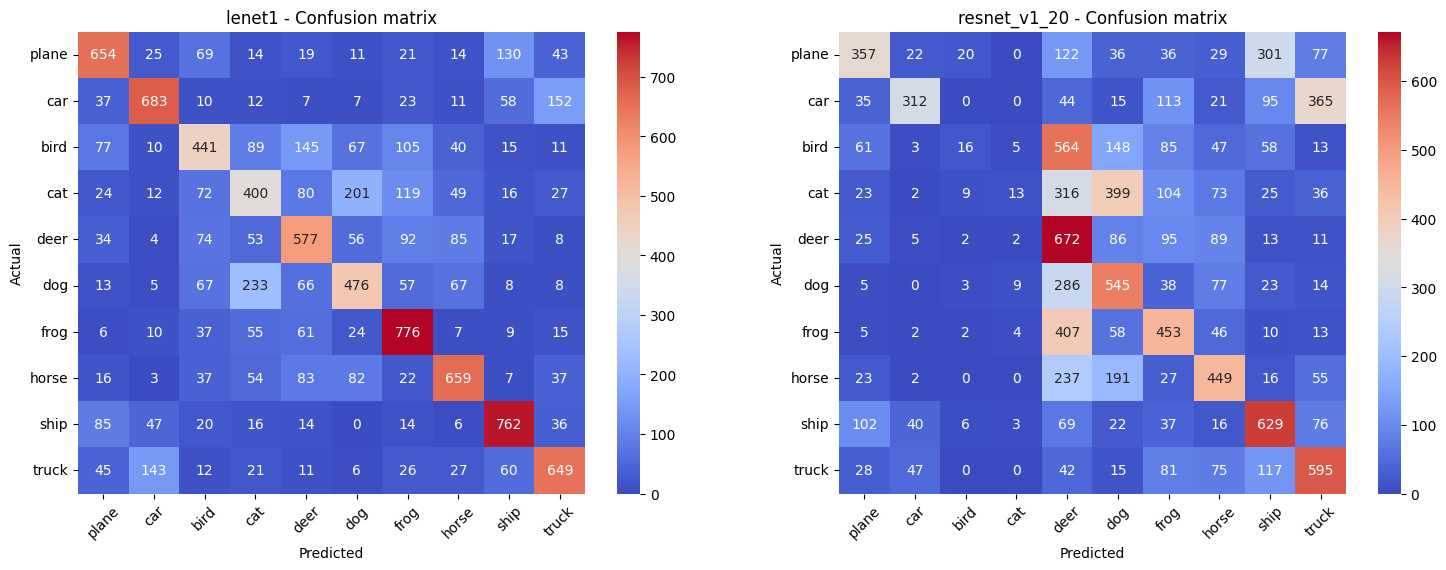

2022-08-09 12:49:01,975: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:49:06,819: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:49:06,825: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1
2022-08-09 12:49:07,138: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:49:07,139: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1
2022-08-09 12:49:08,102: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:49:08,104: INFO: loading model from /tf/eipi10/xuxiangwen.gith

1/1 [==============================] - 0s 103ms/step


2022-08-09 12:49:12,490: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f2ffb568700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 10ms/step


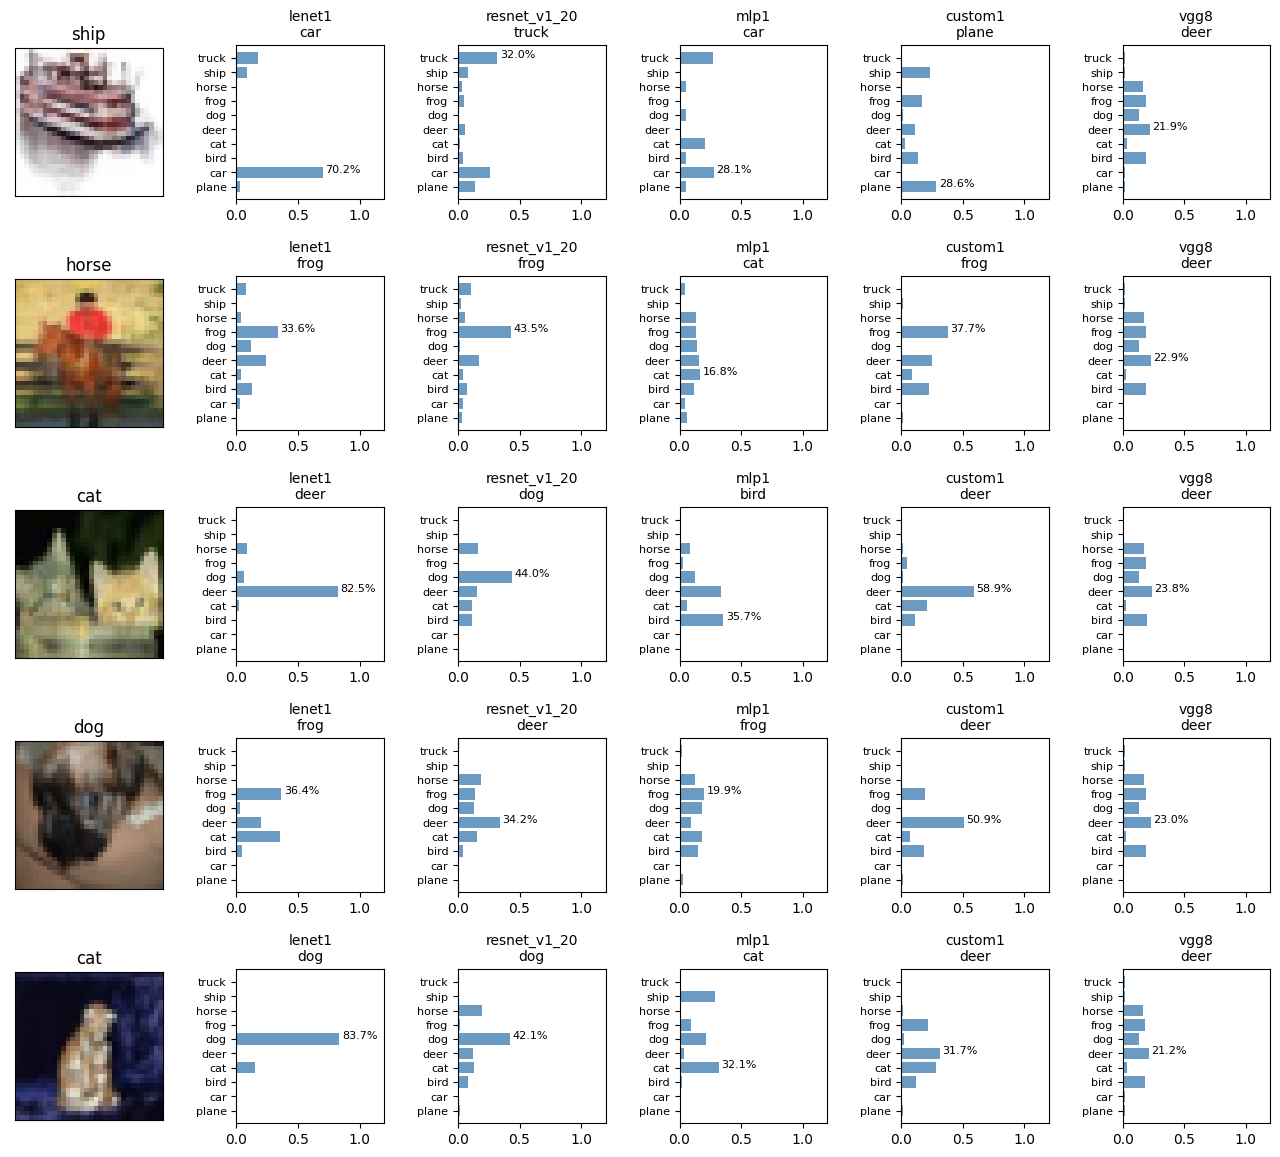

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1        lenet1  cifar10_0808_count_1000.ipynb          83170       330.2   
2  resnet_v1_20  cifar10_0808_count_1000.ipynb         273066        21.6   
3          mlp1  cifar10_0808_count_1000.ipynb         394634       197.3   
4       custom1  cifar10_0808_count_1000.ipynb          73738         5.6   
5          vgg8  cifar10_0808_count_1000.ipynb        1672906        11.1   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:48      0.2686     1.2903          0.9230         0.6077   
2  2022-08-09 05:45      1.6813     1.7428          0.4237         0.4041   
3  2022-08-09 12:42      1.4287     1.7135          0.4881         0.3977   
4  2022-08-09 05:43      2.8900     2.8886          0.1774         0.1772   
5  2022-08-09 05:44      2.7276     2.7176          0.0936         0.1002   

   train_auc  test_auc  
1     0.9968    0.9236  
2     0.8770    0.8637  
3     0.8814    0.8221  
4     0.7707    0.7660  
5     0.6417    0.6417

In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2022-08-09 12:49:16,170: INFO: model_params.custom1.dropout=0.2
2022-08-09 12:49:16,269: INFO: learning_rate=0.001
2022-08-09 12:49:16,270: INFO: model_params.custom1.clip_value=None
2022-08-09 12:49:16,276: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                              

2022-08-09 12:49:16,308: INFO: model_params.custom1.epochs=120
2022-08-09 12:49:16,309: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1, monitor=val_accuracy)
2022-08-09 12:49:16,309: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:49:16,310: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:49:16,311: INFO: use LearningRateScheduler()
2022-08-09 12:49:16,311: INFO: steps_per_epoch=312
2022-08-09 12:49:16,312: INFO: start training
2022-08-09 12:49:16,313: INFO: use_class_weight=False


Epoch 1/120
303/312 [============================>.] - ETA: 0s - loss: 2.0545 - accuracy: 0.2781

2022-08-09 12:49:21,041: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:49:21,722: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 2.0480 - accuracy: 0.2788 - val_loss: 2.8529 - val_accuracy: 0.1763 - lr: 0.0010
Epoch 2/120
308/312 [============================>.] - ETA: 0s - loss: 1.6531 - accuracy: 0.3917

2022-08-09 12:49:26,221: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:49:26,873: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 17ms/step - loss: 1.6526 - accuracy: 0.3913 - val_loss: 1.6777 - val_accuracy: 0.3996 - lr: 0.0010
Epoch 3/120
309/312 [============================>.] - ETA: 0s - loss: 1.5312 - accuracy: 0.4432

2022-08-09 12:49:30,439: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:49:31,073: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 4s 13ms/step - loss: 1.5316 - accuracy: 0.4427 - val_loss: 1.4300 - val_accuracy: 0.4845 - lr: 0.0010
Epoch 4/120
307/312 [============================>.] - ETA: 0s - loss: 1.4259 - accuracy: 0.4824

2022-08-09 12:49:34,744: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:49:35,416: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 1.4264 - accuracy: 0.4814 - val_loss: 1.3914 - val_accuracy: 0.4941 - lr: 0.0010
Epoch 5/120
307/312 [============================>.] - ETA: 0s - loss: 1.3375 - accuracy: 0.5166

2022-08-09 12:49:39,388: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:49:40,433: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 16ms/step - loss: 1.3388 - accuracy: 0.5157 - val_loss: 1.3731 - val_accuracy: 0.5135 - lr: 0.0010
Epoch 6/120
312/312 [==============================] - 3s 8ms/step - loss: 1.2862 - accuracy: 0.5336 - val_loss: 1.4252 - val_accuracy: 0.5080 - lr: 0.0010
Epoch 7/120
305/312 [============================>.] - ETA: 0s - loss: 1.2158 - accuracy: 0.5653

2022-08-09 12:49:46,934: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:49:47,618: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 1.2172 - accuracy: 0.5640 - val_loss: 1.2249 - val_accuracy: 0.5602 - lr: 0.0010
Epoch 8/120
312/312 [==============================] - 2s 8ms/step - loss: 1.1657 - accuracy: 0.5807 - val_loss: 1.4968 - val_accuracy: 0.4896 - lr: 0.0010
Epoch 9/120
312/312 [==============================] - 3s 8ms/step - loss: 1.1250 - accuracy: 0.5968 - val_loss: 1.5318 - val_accuracy: 0.4956 - lr: 0.0010
Epoch 10/120
311/312 [============================>.] - ETA: 0s - loss: 1.0867 - accuracy: 0.6067

2022-08-09 12:49:56,607: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:49:57,286: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 1.0872 - accuracy: 0.6066 - val_loss: 1.2227 - val_accuracy: 0.5770 - lr: 0.0010
Epoch 11/120
312/312 [==============================] - 2s 8ms/step - loss: 1.0675 - accuracy: 0.6120 - val_loss: 1.2623 - val_accuracy: 0.5611 - lr: 0.0010
Epoch 12/120
312/312 [==============================] - 3s 8ms/step - loss: 1.0157 - accuracy: 0.6355 - val_loss: 1.2269 - val_accuracy: 0.5732 - lr: 0.0010
Epoch 13/120
304/312 [============================>.] - ETA: 0s - loss: 0.9952 - accuracy: 0.6414

2022-08-09 12:50:06,258: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:50:06,933: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.9977 - accuracy: 0.6408 - val_loss: 1.1758 - val_accuracy: 0.5873 - lr: 0.0010
Epoch 14/120
312/312 [==============================] - 2s 8ms/step - loss: 0.9721 - accuracy: 0.6490 - val_loss: 1.2318 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 15/120
312/312 [==============================] - 3s 8ms/step - loss: 0.9460 - accuracy: 0.6570 - val_loss: 1.2857 - val_accuracy: 0.5635 - lr: 0.0010
Epoch 16/120
309/312 [============================>.] - ETA: 0s - loss: 0.9147 - accuracy: 0.6760

2022-08-09 12:50:15,470: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:50:16,542: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.9152 - accuracy: 0.6758 - val_loss: 1.1450 - val_accuracy: 0.6022 - lr: 0.0010
Epoch 17/120
312/312 [==============================] - 2s 7ms/step - loss: 0.9094 - accuracy: 0.6770 - val_loss: 1.2168 - val_accuracy: 0.5852 - lr: 0.0010
Epoch 18/120
311/312 [============================>.] - ETA: 0s - loss: 0.8760 - accuracy: 0.6872

2022-08-09 12:50:22,506: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:50:23,190: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.8766 - accuracy: 0.6872 - val_loss: 1.1116 - val_accuracy: 0.6237 - lr: 0.0010
Epoch 19/120
312/312 [==============================] - 2s 8ms/step - loss: 0.8644 - accuracy: 0.6920 - val_loss: 1.1889 - val_accuracy: 0.5978 - lr: 0.0010
Epoch 20/120
312/312 [==============================] - 2s 7ms/step - loss: 0.8406 - accuracy: 0.6960 - val_loss: 1.2759 - val_accuracy: 0.5742 - lr: 0.0010
Epoch 21/120
311/312 [============================>.] - ETA: 0s - loss: 0.8178 - accuracy: 0.7039

2022-08-09 12:50:31,573: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:50:32,220: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.8190 - accuracy: 0.7036 - val_loss: 1.1190 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 22/120
312/312 [==============================] - 2s 7ms/step - loss: 0.8147 - accuracy: 0.7045 - val_loss: 1.2503 - val_accuracy: 0.6003 - lr: 0.0010
Epoch 23/120
304/312 [============================>.] - ETA: 0s - loss: 0.7818 - accuracy: 0.7152

2022-08-09 12:50:38,149: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:50:38,833: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.7824 - accuracy: 0.7158 - val_loss: 1.1175 - val_accuracy: 0.6259 - lr: 0.0010
Epoch 24/120
310/312 [============================>.] - ETA: 0s - loss: 0.7581 - accuracy: 0.7317

2022-08-09 12:50:43,222: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:50:43,943: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 16ms/step - loss: 0.7590 - accuracy: 0.7312 - val_loss: 1.0838 - val_accuracy: 0.6424 - lr: 0.0010
Epoch 25/120
307/312 [============================>.] - ETA: 0s - loss: 0.7584 - accuracy: 0.7333

2022-08-09 12:50:47,887: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:50:48,533: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.7574 - accuracy: 0.7333 - val_loss: 1.0769 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 26/120
306/312 [============================>.] - ETA: 0s - loss: 0.7499 - accuracy: 0.7290

2022-08-09 12:50:52,131: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:50:52,767: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 4s 14ms/step - loss: 0.7506 - accuracy: 0.7288 - val_loss: 1.0757 - val_accuracy: 0.6497 - lr: 0.0010
Epoch 27/120
312/312 [==============================] - 2s 7ms/step - loss: 0.7314 - accuracy: 0.7349 - val_loss: 1.1167 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 28/120
312/312 [==============================] - 2s 7ms/step - loss: 0.7242 - accuracy: 0.7378 - val_loss: 1.1723 - val_accuracy: 0.6253 - lr: 0.0010
Epoch 29/120
310/312 [============================>.] - ETA: 0s - loss: 0.7133 - accuracy: 0.7449

2022-08-09 12:51:01,196: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:51:01,905: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.7142 - accuracy: 0.7445 - val_loss: 1.0555 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 30/120
312/312 [==============================] - 3s 8ms/step - loss: 0.6988 - accuracy: 0.7471 - val_loss: 1.2555 - val_accuracy: 0.6012 - lr: 0.0010
Epoch 31/120
312/312 [==============================] - 3s 8ms/step - loss: 0.6930 - accuracy: 0.7539 - val_loss: 1.2183 - val_accuracy: 0.6073 - lr: 0.0010
Epoch 32/120
312/312 [==============================] - 3s 8ms/step - loss: 0.6925 - accuracy: 0.7516 - val_loss: 1.2016 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 33/120
312/312 [==============================] - 3s 8ms/step - loss: 0.6706 - accuracy: 0.7565 - val_loss: 1.1009 - val_accuracy: 0.6429 - lr: 0.0010
Epoch 34/120
312/312 [==============================] - 2s 8ms/step - loss: 0.6783 - accuracy: 0.7543 - val_loss: 1.1132 - val_accuracy: 0.6421 - lr: 0.0010
Epoch 35/120
312/312 [==============================] - 3s 8ms/step - 

2022-08-09 12:51:29,001: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:51:29,707: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 16ms/step - loss: 0.6324 - accuracy: 0.7721 - val_loss: 1.0750 - val_accuracy: 0.6595 - lr: 0.0010
Epoch 40/120
312/312 [==============================] - 2s 8ms/step - loss: 0.6272 - accuracy: 0.7740 - val_loss: 1.3175 - val_accuracy: 0.6043 - lr: 0.0010
Epoch 41/120
311/312 [============================>.] - ETA: 0s - loss: 0.6254 - accuracy: 0.7750

2022-08-09 12:51:36,224: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:51:36,913: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.6260 - accuracy: 0.7747 - val_loss: 1.0725 - val_accuracy: 0.6654 - lr: 0.0010
Epoch 42/120
312/312 [==============================] - 3s 8ms/step - loss: 0.6110 - accuracy: 0.7832 - val_loss: 1.1892 - val_accuracy: 0.6377 - lr: 0.0010
Epoch 43/120
312/312 [==============================] - 2s 8ms/step - loss: 0.6073 - accuracy: 0.7792 - val_loss: 1.1728 - val_accuracy: 0.6389 - lr: 0.0010
Epoch 44/120
307/312 [============================>.] - ETA: 0s - loss: 0.5981 - accuracy: 0.7863
Epoch 44: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
312/312 [==============================] - 3s 8ms/step - loss: 0.5989 - accuracy: 0.7861 - val_loss: 1.1639 - val_accuracy: 0.6381 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/120
312/312 [==============================] - 2s 8ms/step - loss: 0.5432 - accuracy: 0.8028 - val_loss: 1.1097 - val_accuracy: 0.6607 - lr: 3.

2022-08-09 12:51:58,512: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:51:59,190: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.4934 - accuracy: 0.8212 - val_loss: 1.0859 - val_accuracy: 0.6744 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/120
312/312 [==============================] - 2s 8ms/step - loss: 0.4889 - accuracy: 0.8246 - val_loss: 1.1537 - val_accuracy: 0.6576 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4877 - accuracy: 0.8206 - val_loss: 1.1317 - val_accuracy: 0.6639 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/120
312/312 [==============================] - 2s 8ms/step - loss: 0.4888 - accuracy: 0.8221 - val_loss: 1.2045 - val_accuracy: 0.6474 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4782 - accuracy: 0.8289 - val_

2022-08-09 12:52:23,298: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:52:23,972: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.4666 - accuracy: 0.8361 - val_loss: 1.0957 - val_accuracy: 0.6772 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/120
311/312 [============================>.] - ETA: 0s - loss: 0.4593 - accuracy: 0.8304
Epoch 59: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
312/312 [==============================] - 2s 8ms/step - loss: 0.4597 - accuracy: 0.8302 - val_loss: 1.1091 - val_accuracy: 0.6706 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4415 - accuracy: 0.8365 - val_loss: 1.2233 - val_accuracy: 0.6605 - lr: 1.0000e-04
Epoch 61/120
312/312 [==============================] - 2s 8ms/step - loss: 0.4426 - accuracy: 0.8401 - val_loss: 1.2330 - val_accuracy: 0.6583 - lr: 1.0000e-04
Epoch 62/120
312/312 [==============================] - 3s 8ms/step - loss: 0.

2022-08-09 12:52:40,931: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:52:41,652: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 17ms/step - loss: 0.4395 - accuracy: 0.8384 - val_loss: 1.1082 - val_accuracy: 0.6810 - lr: 1.0000e-04
Epoch 65/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4320 - accuracy: 0.8454 - val_loss: 1.2842 - val_accuracy: 0.6498 - lr: 1.0000e-04
Epoch 66/120
312/312 [==============================] - 2s 8ms/step - loss: 0.4255 - accuracy: 0.8492 - val_loss: 1.1947 - val_accuracy: 0.6650 - lr: 1.0000e-04
Epoch 67/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4250 - accuracy: 0.8500 - val_loss: 1.0959 - val_accuracy: 0.6783 - lr: 1.0000e-04
Epoch 68/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4191 - accuracy: 0.8525 - val_loss: 1.1864 - val_accuracy: 0.6690 - lr: 1.0000e-04
Epoch 69/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4168 - accuracy: 0.8501 - val_loss: 1.1610 - val_accuracy: 0.6717 - lr: 1.0000e-04
Epoch 70/120
312/312 [========================

2022-08-09 12:53:18,411: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:53:19,066: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.4014 - accuracy: 0.8598 - val_loss: 1.1125 - val_accuracy: 0.6820 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/120
312/312 [==============================] - 2s 7ms/step - loss: 0.4146 - accuracy: 0.8511 - val_loss: 1.1336 - val_accuracy: 0.6768 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
312/312 [==============================] - 2s 7ms/step - loss: 0.4100 - accuracy: 0.8514 - val_loss: 1.1325 - val_accuracy: 0.6784 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
312/312 [==============================] - 2s 7ms/step - loss: 0.4115 - accuracy: 0.8499 - val_loss: 1.1561 - val_accuracy: 0.6766 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/120
312/312 [==============================] - 2s 7ms/step - loss: 0.4005 - accuracy: 0.8502 - val_

2022-08-09 12:53:31,835: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:53:32,513: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.4010 - accuracy: 0.8514 - val_loss: 1.1109 - val_accuracy: 0.6833 - lr: 3.1623e-05
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/120
312/312 [==============================] - 2s 7ms/step - loss: 0.4062 - accuracy: 0.8522 - val_loss: 1.1446 - val_accuracy: 0.6773 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/120
312/312 [==============================] - 2s 7ms/step - loss: 0.4002 - accuracy: 0.8588 - val_loss: 1.1205 - val_accuracy: 0.6801 - lr: 3.1623e-05
Epoch 00086: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 86/120
312/312 [==============================] - 2s 7ms/step - loss: 0.4005 - accuracy: 0.8577 - val_loss: 1.1248 - val_accuracy: 0.6789 - lr: 3.1623e-05
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 87/120
312/312 [==============================] - 2s 7ms/step - loss: 0.4016 - accuracy: 0.8526 - val_

2022-08-09 12:54:06,036: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:54:06,700: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.3991 - accuracy: 0.8585 - val_loss: 1.1058 - val_accuracy: 0.6837 - lr: 1.0000e-05
Epoch 98/120
312/312 [==============================] - 3s 8ms/step - loss: 0.3973 - accuracy: 0.8608 - val_loss: 1.1126 - val_accuracy: 0.6813 - lr: 1.0000e-05
Epoch 99/120
312/312 [==============================] - 2s 8ms/step - loss: 0.3872 - accuracy: 0.8577 - val_loss: 1.1098 - val_accuracy: 0.6820 - lr: 1.0000e-05
Epoch 100/120
312/312 [==============================] - 3s 8ms/step - loss: 0.3981 - accuracy: 0.8561 - val_loss: 1.1131 - val_accuracy: 0.6812 - lr: 1.0000e-05
Epoch 101/120
312/312 [==============================] - 2s 8ms/step - loss: 0.4050 - accuracy: 0.8515 - val_loss: 1.1125 - val_accuracy: 0.6817 - lr: 1.0000e-05
Epoch 102/120
312/312 [==============================] - 3s 8ms/step - loss: 0.3961 - accuracy: 0.8534 - val_loss: 1.1135 - val_accuracy: 0.6819 - lr: 1.0000e-05
Epoch 103/120
311/312 [====================

2022-08-09 12:54:23,610: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:54:24,332: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 16ms/step - loss: 0.3942 - accuracy: 0.8569 - val_loss: 1.1068 - val_accuracy: 0.6845 - lr: 1.0000e-05
Epoch 104/120
305/312 [============================>.] - ETA: 0s - loss: 0.3990 - accuracy: 0.8529
Epoch 104: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
312/312 [==============================] - 3s 8ms/step - loss: 0.3993 - accuracy: 0.8532 - val_loss: 1.1115 - val_accuracy: 0.6835 - lr: 3.1623e-06
Epoch 00105: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 105/120
312/312 [==============================] - 3s 8ms/step - loss: 0.3852 - accuracy: 0.8591 - val_loss: 1.1080 - val_accuracy: 0.6839 - lr: 3.1623e-06
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 3.2e-06.
Epoch 106/120
305/312 [============================>.] - ETA: 0s - loss: 0.3905 - accuracy: 0.8589

2022-08-09 12:54:33,448: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:54:34,158: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.3903 - accuracy: 0.8587 - val_loss: 1.1024 - val_accuracy: 0.6849 - lr: 1.0000e-06
Epoch 107/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4023 - accuracy: 0.8534 - val_loss: 1.1040 - val_accuracy: 0.6844 - lr: 1.0000e-06
Epoch 108/120
312/312 [==============================] - 2s 8ms/step - loss: 0.3955 - accuracy: 0.8583 - val_loss: 1.1031 - val_accuracy: 0.6847 - lr: 1.0000e-06
Epoch 109/120
308/312 [============================>.] - ETA: 0s - loss: 0.3972 - accuracy: 0.8569

2022-08-09 12:54:43,200: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:54:43,877: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.3976 - accuracy: 0.8567 - val_loss: 1.1033 - val_accuracy: 0.6853 - lr: 1.0000e-06
Epoch 110/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4063 - accuracy: 0.8513 - val_loss: 1.1037 - val_accuracy: 0.6849 - lr: 1.0000e-06
Epoch 111/120
312/312 [==============================] - 2s 8ms/step - loss: 0.3933 - accuracy: 0.8577 - val_loss: 1.1028 - val_accuracy: 0.6852 - lr: 1.0000e-06
Epoch 112/120
304/312 [============================>.] - ETA: 0s - loss: 0.4003 - accuracy: 0.8545

2022-08-09 12:54:52,871: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


2022-08-09 12:54:53,540: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1/assets


312/312 [==============================] - 5s 15ms/step - loss: 0.4001 - accuracy: 0.8555 - val_loss: 1.1030 - val_accuracy: 0.6856 - lr: 1.0000e-06
Epoch 113/120
312/312 [==============================] - 3s 8ms/step - loss: 0.4013 - accuracy: 0.8553 - val_loss: 1.1038 - val_accuracy: 0.6849 - lr: 1.0000e-06
Epoch 114/120
312/312 [==============================] - 2s 8ms/step - loss: 0.3948 - accuracy: 0.8544 - val_loss: 1.1040 - val_accuracy: 0.6853 - lr: 1.0000e-06
Epoch 115/120
312/312 [==============================] - 3s 8ms/step - loss: 0.3948 - accuracy: 0.8547 - val_loss: 1.1033 - val_accuracy: 0.6852 - lr: 1.0000e-06
Epoch 116/120
312/312 [==============================] - 2s 8ms/step - loss: 0.3885 - accuracy: 0.8616 - val_loss: 1.1030 - val_accuracy: 0.6855 - lr: 1.0000e-06
Epoch 117/120
312/312 [==============================] - 3s 8ms/step - loss: 0.3925 - accuracy: 0.8590 - val_loss: 1.1042 - val_accuracy: 0.6853 - lr: 1.0000e-06
Epoch 118/120
312/312 [==================

2022-08-09 12:55:13,767: INFO: finish training [elapsed time: 357.46 seconds]


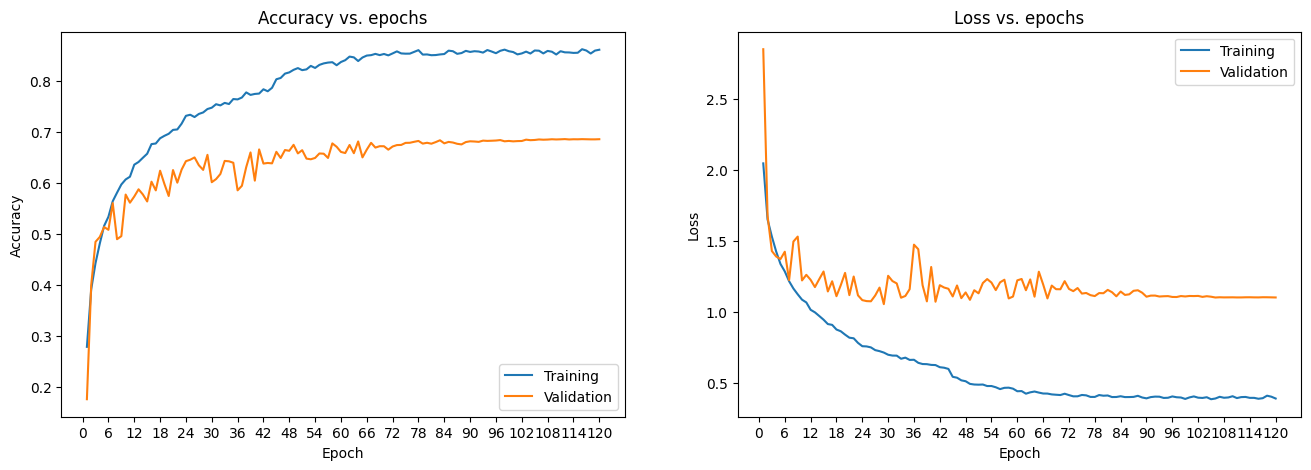

2022-08-09 12:55:14,217: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-09 12:55:22,608: INFO: test loss:1.1030
2022-08-09 12:55:22,609: INFO: test accuracy:0.6856
2022-08-09 12:55:22,611: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 12:55:22,613: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 12:55:22,614: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:55:22,615: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:55:22,616: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 12:55:23,438: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator


313/313 [==============================] - 1s 2ms/step


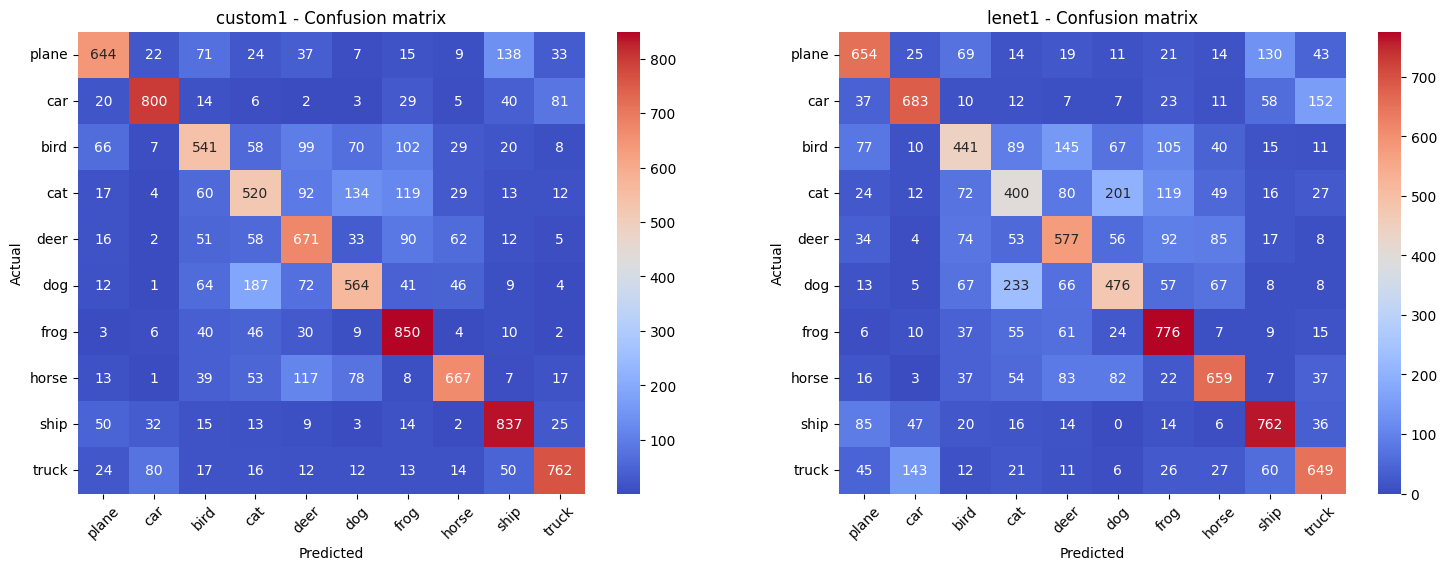

2022-08-09 12:55:28,119: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1


----------------------------------------sample analysis----------------------------------------


2022-08-09 12:55:29,009: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:55:29,013: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20
2022-08-09 12:55:33,888: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:55:33,897: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/mlp1
2022-08-09 12:55:34,199: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 12:55:34,201: INFO: loading model from /tf/eipi10/xuxiangwen

1/1 [==============================] - 0s 12ms/step


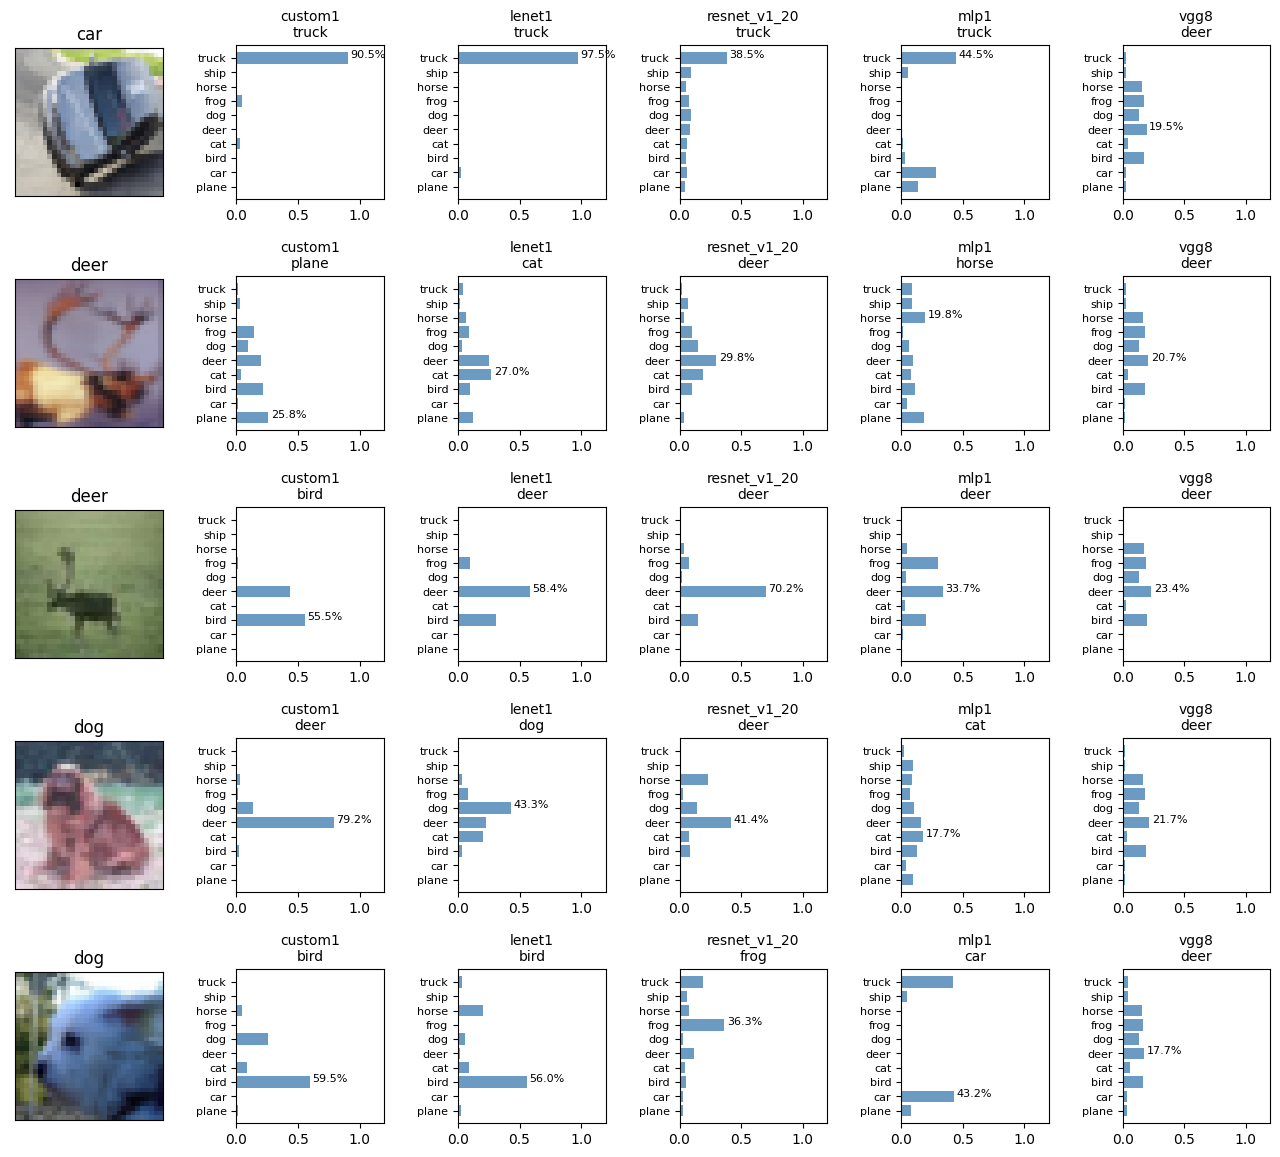

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1       custom1  cifar10_0808_count_1000.ipynb          73738       357.5   
2        lenet1  cifar10_0808_count_1000.ipynb          83170       330.2   
3  resnet_v1_20  cifar10_0808_count_1000.ipynb         273066        21.6   
4          mlp1  cifar10_0808_count_1000.ipynb         394634       197.3   
5          vgg8  cifar10_0808_count_1000.ipynb        1672906        11.1   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 12:55      0.1258     1.1030          0.9688         0.6856   
2  2022-08-09 12:48      0.2686     1.2903          0.9230         0.6077   
3  2022-08-09 05:45      1.6813     1.7428          0.4237         0.4041   
4  2022-08-09 12:42      1.4287     1.7135          0.4881         0.3977   
5  2022-08-09 05:44      2.7276     2.7176          0.0936         0.1002   

   train_auc  test_auc  
1     0.9994    0.9503  
2     0.9968    0.9236  
3     0.8770    0.8637  
4     0.8814    0.8221  
5     0.6417    0.6417

In [22]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2022-08-09 12:55:42,845: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 12:55:43,018: INFO: learning_rate=0.001
2022-08-09 12:55:43,019: INFO: model_params.vgg8.clip_value=None
2022-08-09 12:55:43,025: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                         

2022-08-09 12:55:43,077: INFO: model_params.vgg8.epochs=120
2022-08-09 12:55:43,078: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8, monitor=val_accuracy)
2022-08-09 12:55:43,078: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 12:55:43,079: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 12:55:43,080: INFO: use LearningRateScheduler()
2022-08-09 12:55:43,080: INFO: steps_per_epoch=312
2022-08-09 12:55:43,081: INFO: start training
2022-08-09 12:55:43,082: INFO: use_class_weight=False


Epoch 1/120
312/312 [==============================] - ETA: 0s - loss: 2.2339 - accuracy: 0.1706

2022-08-09 12:55:51,186: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:55:52,319: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 9s 26ms/step - loss: 2.2339 - accuracy: 0.1706 - val_loss: 2.6750 - val_accuracy: 0.1503 - lr: 0.0010
Epoch 2/120
308/312 [============================>.] - ETA: 0s - loss: 1.9676 - accuracy: 0.2221

2022-08-09 12:55:59,264: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:56:00,402: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 26ms/step - loss: 1.9667 - accuracy: 0.2217 - val_loss: 1.8385 - val_accuracy: 0.2948 - lr: 0.0010
Epoch 3/120
312/312 [==============================] - 4s 14ms/step - loss: 1.9124 - accuracy: 0.2413 - val_loss: 1.7835 - val_accuracy: 0.2829 - lr: 0.0010
Epoch 4/120
312/312 [==============================] - 4s 14ms/step - loss: 1.8684 - accuracy: 0.2560 - val_loss: 1.7910 - val_accuracy: 0.2827 - lr: 0.0010
Epoch 5/120
312/312 [==============================] - 5s 15ms/step - loss: 1.8406 - accuracy: 0.2537 - val_loss: 1.9714 - val_accuracy: 0.2536 - lr: 0.0010
Epoch 6/120
312/312 [==============================] - ETA: 0s - loss: 1.8041 - accuracy: 0.2673

2022-08-09 12:56:20,589: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:56:21,702: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 1.8041 - accuracy: 0.2673 - val_loss: 1.7028 - val_accuracy: 0.3091 - lr: 0.0010
Epoch 7/120
310/312 [============================>.] - ETA: 0s - loss: 1.7705 - accuracy: 0.2927

2022-08-09 12:56:29,131: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:56:30,542: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 9s 28ms/step - loss: 1.7703 - accuracy: 0.2926 - val_loss: 1.5541 - val_accuracy: 0.4221 - lr: 0.0010
Epoch 8/120
312/312 [==============================] - 4s 14ms/step - loss: 1.7109 - accuracy: 0.3194 - val_loss: 1.5774 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 9/120
312/312 [==============================] - 4s 14ms/step - loss: 1.6527 - accuracy: 0.3405 - val_loss: 1.5178 - val_accuracy: 0.4099 - lr: 0.0010
Epoch 10/120
312/312 [==============================] - 4s 14ms/step - loss: 1.6033 - accuracy: 0.3624 - val_loss: 1.6093 - val_accuracy: 0.3805 - lr: 0.0010
Epoch 11/120
312/312 [==============================] - 4s 14ms/step - loss: 1.5564 - accuracy: 0.3844 - val_loss: 2.3953 - val_accuracy: 0.2554 - lr: 0.0010
Epoch 12/120
310/312 [============================>.] - ETA: 0s - loss: 1.5122 - accuracy: 0.4106

2022-08-09 12:56:54,027: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:56:55,044: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 24ms/step - loss: 1.5127 - accuracy: 0.4102 - val_loss: 1.3174 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 13/120
312/312 [==============================] - 4s 14ms/step - loss: 1.4685 - accuracy: 0.4290 - val_loss: 1.3758 - val_accuracy: 0.4741 - lr: 0.0010
Epoch 14/120
312/312 [==============================] - 4s 14ms/step - loss: 1.4557 - accuracy: 0.4313 - val_loss: 1.3797 - val_accuracy: 0.4684 - lr: 0.0010
Epoch 15/120
312/312 [==============================] - 4s 14ms/step - loss: 1.3963 - accuracy: 0.4588 - val_loss: 1.3577 - val_accuracy: 0.4908 - lr: 0.0010
Epoch 16/120
312/312 [==============================] - ETA: 0s - loss: 1.3721 - accuracy: 0.4630

2022-08-09 12:57:14,186: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:57:15,212: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 1.3721 - accuracy: 0.4630 - val_loss: 1.1720 - val_accuracy: 0.5570 - lr: 0.0010
Epoch 17/120
312/312 [==============================] - 4s 14ms/step - loss: 1.3392 - accuracy: 0.4804 - val_loss: 1.2242 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 18/120
307/312 [============================>.] - ETA: 0s - loss: 1.3112 - accuracy: 0.4912

2022-08-09 12:57:26,351: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:57:27,419: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 26ms/step - loss: 1.3103 - accuracy: 0.4917 - val_loss: 1.2501 - val_accuracy: 0.5616 - lr: 0.0010
Epoch 19/120
311/312 [============================>.] - ETA: 0s - loss: 1.2668 - accuracy: 0.5106

2022-08-09 12:57:33,906: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:57:34,932: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 1.2666 - accuracy: 0.5110 - val_loss: 1.2190 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 20/120
312/312 [==============================] - 4s 14ms/step - loss: 1.2455 - accuracy: 0.5229 - val_loss: 1.1207 - val_accuracy: 0.5961 - lr: 0.0010
Epoch 21/120
312/312 [==============================] - 4s 14ms/step - loss: 1.2193 - accuracy: 0.5298 - val_loss: 1.1853 - val_accuracy: 0.5828 - lr: 0.0010
Epoch 22/120
312/312 [==============================] - ETA: 0s - loss: 1.2086 - accuracy: 0.5388

2022-08-09 12:57:49,834: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:57:50,863: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 1.2086 - accuracy: 0.5388 - val_loss: 1.0589 - val_accuracy: 0.6193 - lr: 0.0010
Epoch 23/120
312/312 [==============================] - 4s 14ms/step - loss: 1.1667 - accuracy: 0.5605 - val_loss: 1.1552 - val_accuracy: 0.6066 - lr: 0.0010
Epoch 24/120
312/312 [==============================] - 4s 14ms/step - loss: 1.1151 - accuracy: 0.5727 - val_loss: 1.0936 - val_accuracy: 0.6177 - lr: 0.0010
Epoch 25/120
309/312 [============================>.] - ETA: 0s - loss: 1.0790 - accuracy: 0.5891

2022-08-09 12:58:06,204: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:58:07,227: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 1.0802 - accuracy: 0.5889 - val_loss: 1.1050 - val_accuracy: 0.6415 - lr: 0.0010
Epoch 26/120
312/312 [==============================] - 4s 14ms/step - loss: 1.0256 - accuracy: 0.6025 - val_loss: 1.2070 - val_accuracy: 0.6256 - lr: 0.0010
Epoch 27/120
312/312 [==============================] - 4s 14ms/step - loss: 1.0098 - accuracy: 0.6146 - val_loss: 1.2658 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 28/120
312/312 [==============================] - 4s 14ms/step - loss: 0.9712 - accuracy: 0.6275 - val_loss: 1.4108 - val_accuracy: 0.6205 - lr: 0.0010
Epoch 29/120
312/312 [==============================] - ETA: 0s - loss: 0.9247 - accuracy: 0.6532

2022-08-09 12:58:26,451: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:58:27,474: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 0.9247 - accuracy: 0.6532 - val_loss: 1.0724 - val_accuracy: 0.6660 - lr: 0.0010
Epoch 30/120
312/312 [==============================] - 4s 14ms/step - loss: 0.8841 - accuracy: 0.6690 - val_loss: 1.1370 - val_accuracy: 0.6483 - lr: 0.0010
Epoch 31/120
307/312 [============================>.] - ETA: 0s - loss: 0.8508 - accuracy: 0.6787

2022-08-09 12:58:38,556: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:58:39,597: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.8506 - accuracy: 0.6788 - val_loss: 1.0359 - val_accuracy: 0.6664 - lr: 0.0010
Epoch 32/120
310/312 [============================>.] - ETA: 0s - loss: 0.8170 - accuracy: 0.6862

2022-08-09 12:58:46,016: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:58:47,019: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 0.8169 - accuracy: 0.6866 - val_loss: 0.9531 - val_accuracy: 0.6993 - lr: 0.0010
Epoch 33/120
312/312 [==============================] - 4s 14ms/step - loss: 0.7859 - accuracy: 0.7055 - val_loss: 0.9982 - val_accuracy: 0.6716 - lr: 0.0010
Epoch 34/120
311/312 [============================>.] - ETA: 0s - loss: 0.7613 - accuracy: 0.7163

2022-08-09 12:58:58,033: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:58:59,094: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.7620 - accuracy: 0.7159 - val_loss: 0.8990 - val_accuracy: 0.7104 - lr: 0.0010
Epoch 35/120
312/312 [==============================] - 4s 14ms/step - loss: 0.7350 - accuracy: 0.7225 - val_loss: 1.2979 - val_accuracy: 0.6597 - lr: 0.0010
Epoch 36/120
312/312 [==============================] - 4s 14ms/step - loss: 0.7120 - accuracy: 0.7322 - val_loss: 1.0945 - val_accuracy: 0.6822 - lr: 0.0010
Epoch 37/120
312/312 [==============================] - 4s 14ms/step - loss: 0.6821 - accuracy: 0.7426 - val_loss: 1.1836 - val_accuracy: 0.6874 - lr: 0.0010
Epoch 38/120
312/312 [==============================] - 4s 14ms/step - loss: 0.6741 - accuracy: 0.7449 - val_loss: 1.0287 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 39/120
307/312 [============================>.] - ETA: 0s - loss: 0.6441 - accuracy: 0.7603

2022-08-09 12:59:22,572: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:59:23,610: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 0.6464 - accuracy: 0.7596 - val_loss: 0.9802 - val_accuracy: 0.7137 - lr: 0.0010
Epoch 40/120
312/312 [==============================] - 4s 14ms/step - loss: 0.6117 - accuracy: 0.7733 - val_loss: 0.9987 - val_accuracy: 0.6872 - lr: 0.0010
Epoch 41/120
312/312 [==============================] - 4s 14ms/step - loss: 0.5867 - accuracy: 0.7823 - val_loss: 1.3883 - val_accuracy: 0.6564 - lr: 0.0010
Epoch 42/120
307/312 [============================>.] - ETA: 0s - loss: 0.5614 - accuracy: 0.7868

2022-08-09 12:59:38,547: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 12:59:39,572: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 0.5634 - accuracy: 0.7863 - val_loss: 0.9703 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 43/120
312/312 [==============================] - 4s 14ms/step - loss: 0.5660 - accuracy: 0.7860 - val_loss: 1.0597 - val_accuracy: 0.6819 - lr: 0.0010
Epoch 44/120
312/312 [==============================] - 4s 14ms/step - loss: 0.5464 - accuracy: 0.7970 - val_loss: 1.0160 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 45/120
312/312 [==============================] - 4s 14ms/step - loss: 0.5122 - accuracy: 0.8050 - val_loss: 1.0138 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 46/120
312/312 [==============================] - 4s 14ms/step - loss: 0.4921 - accuracy: 0.8173 - val_loss: 1.1623 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 47/120
309/312 [============================>.] - ETA: 0s - loss: 0.5018 - accuracy: 0.8122

2022-08-09 13:00:03,571: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:00:04,667: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 26ms/step - loss: 0.5041 - accuracy: 0.8118 - val_loss: 0.9497 - val_accuracy: 0.7278 - lr: 0.0010
Epoch 48/120
312/312 [==============================] - 4s 14ms/step - loss: 0.4777 - accuracy: 0.8168 - val_loss: 1.1130 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 49/120
310/312 [============================>.] - ETA: 0s - loss: 0.4624 - accuracy: 0.8296

2022-08-09 13:00:15,591: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:00:16,613: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets



Epoch 49: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
312/312 [==============================] - 8s 24ms/step - loss: 0.4636 - accuracy: 0.8292 - val_loss: 0.9672 - val_accuracy: 0.7407 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/120
312/312 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8580

2022-08-09 13:00:23,435: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:00:24,467: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.3854 - accuracy: 0.8580 - val_loss: 0.9666 - val_accuracy: 0.7579 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/120
312/312 [==============================] - 4s 14ms/step - loss: 0.3488 - accuracy: 0.8695 - val_loss: 0.9542 - val_accuracy: 0.7519 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/120
307/312 [============================>.] - ETA: 0s - loss: 0.3364 - accuracy: 0.8766

2022-08-09 13:00:35,226: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:00:36,264: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 24ms/step - loss: 0.3369 - accuracy: 0.8766 - val_loss: 0.9744 - val_accuracy: 0.7619 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/120
312/312 [==============================] - ETA: 0s - loss: 0.3234 - accuracy: 0.8829

2022-08-09 13:00:43,098: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:00:44,208: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 26ms/step - loss: 0.3234 - accuracy: 0.8829 - val_loss: 0.9721 - val_accuracy: 0.7676 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/120
312/312 [==============================] - 4s 14ms/step - loss: 0.3165 - accuracy: 0.8860 - val_loss: 0.9874 - val_accuracy: 0.7653 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/120
312/312 [==============================] - 4s 14ms/step - loss: 0.2984 - accuracy: 0.8914 - val_loss: 0.9889 - val_accuracy: 0.7653 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/120
312/312 [==============================] - 4s 14ms/step - loss: 0.2889 - accuracy: 0.8942 - val_loss: 1.0440 - val_accuracy: 0.7573 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/120
312/312 [==============================] - 4s 14ms/step - loss: 0.2723 - accuracy: 0.9004 - 

2022-08-09 13:01:07,687: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:01:08,712: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 0.2620 - accuracy: 0.9051 - val_loss: 1.0147 - val_accuracy: 0.7697 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/120
312/312 [==============================] - 4s 14ms/step - loss: 0.2529 - accuracy: 0.9077 - val_loss: 1.0559 - val_accuracy: 0.7635 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/120
312/312 [==============================] - 4s 14ms/step - loss: 0.2567 - accuracy: 0.9054 - val_loss: 1.0364 - val_accuracy: 0.7674 - lr: 3.1623e-04
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
Epoch 61/120
311/312 [============================>.] - ETA: 0s - loss: 0.2452 - accuracy: 0.9108

2022-08-09 13:01:23,654: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:01:24,676: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 0.2452 - accuracy: 0.9108 - val_loss: 1.0412 - val_accuracy: 0.7759 - lr: 1.0000e-04
Epoch 62/120
312/312 [==============================] - 4s 14ms/step - loss: 0.2218 - accuracy: 0.9158 - val_loss: 1.0461 - val_accuracy: 0.7749 - lr: 1.0000e-04
Epoch 63/120
312/312 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9264

2022-08-09 13:01:35,811: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:01:36,833: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.2154 - accuracy: 0.9264 - val_loss: 1.0821 - val_accuracy: 0.7765 - lr: 1.0000e-04
Epoch 64/120
309/312 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9251
Epoch 64: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
312/312 [==============================] - 4s 14ms/step - loss: 0.2113 - accuracy: 0.9250 - val_loss: 1.0627 - val_accuracy: 0.7750 - lr: 3.1623e-05
Epoch 00065: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 65/120
312/312 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9293

2022-08-09 13:01:47,511: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:01:48,571: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 0.2000 - accuracy: 0.9293 - val_loss: 1.0718 - val_accuracy: 0.7779 - lr: 3.1623e-05
Epoch 00066: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 66/120
312/312 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.9277

2022-08-09 13:01:55,409: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:01:56,457: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.1997 - accuracy: 0.9277 - val_loss: 1.0736 - val_accuracy: 0.7781 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/120
310/312 [============================>.] - ETA: 0s - loss: 0.1945 - accuracy: 0.9287

2022-08-09 13:02:02,970: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:02:03,983: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 0.1946 - accuracy: 0.9285 - val_loss: 1.0822 - val_accuracy: 0.7785 - lr: 3.1623e-05
Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1986 - accuracy: 0.9298 - val_loss: 1.0659 - val_accuracy: 0.7782 - lr: 3.1623e-05
Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/120
310/312 [============================>.] - ETA: 0s - loss: 0.1922 - accuracy: 0.9321

2022-08-09 13:02:15,013: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:02:16,082: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 8s 25ms/step - loss: 0.1924 - accuracy: 0.9320 - val_loss: 1.0744 - val_accuracy: 0.7790 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1934 - accuracy: 0.9292 - val_loss: 1.0781 - val_accuracy: 0.7783 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1978 - accuracy: 0.9272 - val_loss: 1.0729 - val_accuracy: 0.7771 - lr: 3.1623e-05
Epoch 00072: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 72/120
312/312 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9291

2022-08-09 13:02:31,088: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


2022-08-09 13:02:32,117: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8/assets


312/312 [==============================] - 7s 24ms/step - loss: 0.1956 - accuracy: 0.9291 - val_loss: 1.0663 - val_accuracy: 0.7814 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1966 - accuracy: 0.9302 - val_loss: 1.0813 - val_accuracy: 0.7782 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1899 - accuracy: 0.9290 - val_loss: 1.0746 - val_accuracy: 0.7808 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1926 - accuracy: 0.9318 - val_loss: 1.0830 - val_accuracy: 0.7812 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1986 - accuracy: 0.9269 - 

Epoch 109/120
312/312 [==============================] - ETA: 0s - loss: 0.1833 - accuracy: 0.9353
Epoch 109: ReduceLROnPlateau reducing learning rate to 5e-07.
312/312 [==============================] - 4s 14ms/step - loss: 0.1833 - accuracy: 0.9353 - val_loss: 1.1063 - val_accuracy: 0.7804 - lr: 5.0000e-07
Epoch 00110: Still keep learning rate 5e-07 instead of 1e-06
Epoch 110/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1743 - accuracy: 0.9377 - val_loss: 1.1029 - val_accuracy: 0.7806 - lr: 5.0000e-07
Epoch 00111: Still keep learning rate 5e-07 instead of 1e-06
Epoch 111/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1828 - accuracy: 0.9353 - val_loss: 1.1020 - val_accuracy: 0.7807 - lr: 5.0000e-07
Epoch 00112: Still keep learning rate 5e-07 instead of 1e-06
Epoch 112/120
312/312 [==============================] - 4s 14ms/step - loss: 0.1816 - accuracy: 0.9351 - val_loss: 1.1037 - val_accuracy: 0.7804 - lr: 5.0000e-07
Epoch 112: early s

2022-08-09 13:05:22,111: INFO: finish training [elapsed time: 579.03 seconds]


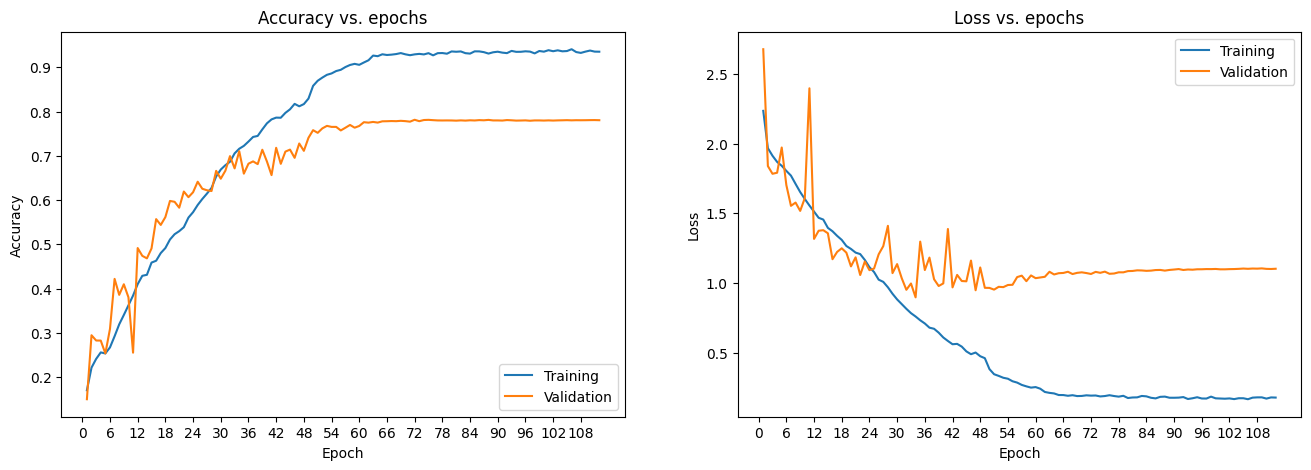

2022-08-09 13:05:22,509: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-09 13:05:31,935: INFO: test loss:1.0663
2022-08-09 13:05:31,936: INFO: test accuracy:0.7814
2022-08-09 13:05:31,938: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 13:05:31,940: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 13:05:31,940: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:05:31,941: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:05:31,942: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 13:05:33,299: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator


313/313 [==============================] - 1s 2ms/step


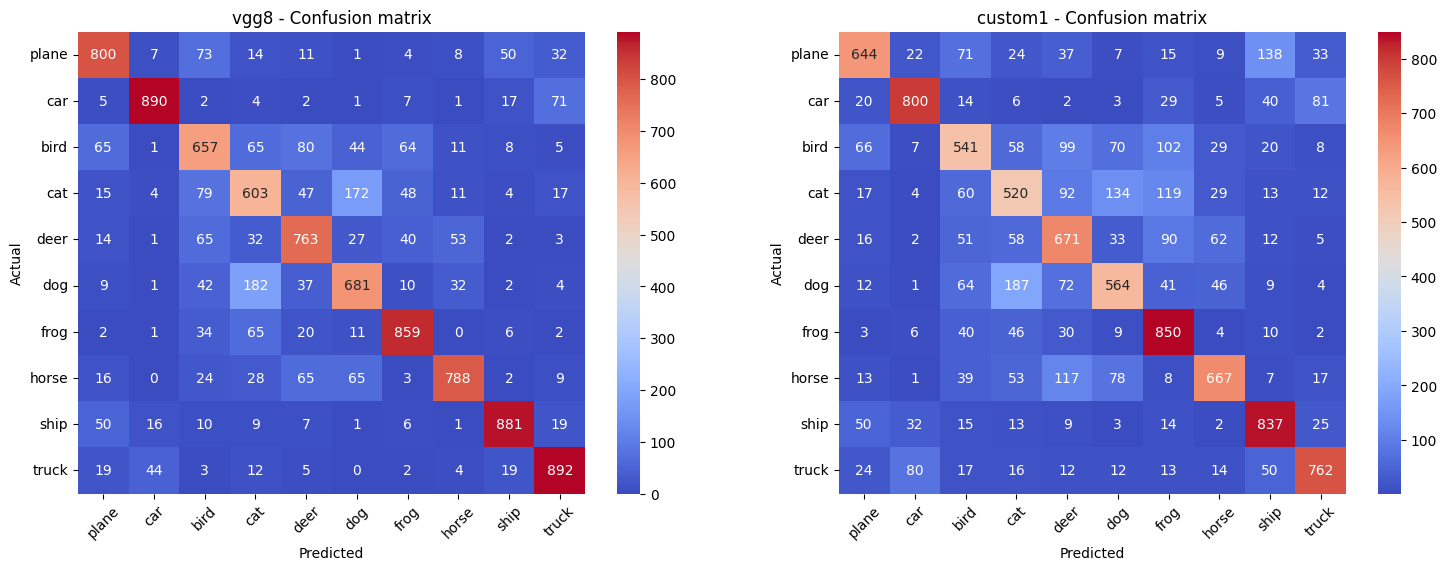

2022-08-09 13:05:38,173: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1


----------------------------------------sample analysis----------------------------------------


2022-08-09 13:05:39,105: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:05:39,109: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1
2022-08-09 13:05:39,888: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:05:39,892: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20
2022-08-09 13:05:44,446: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:05:44,453: INFO: loading model from /tf/eipi10/xuxiangw

1/1 [==============================] - 0s 8ms/step


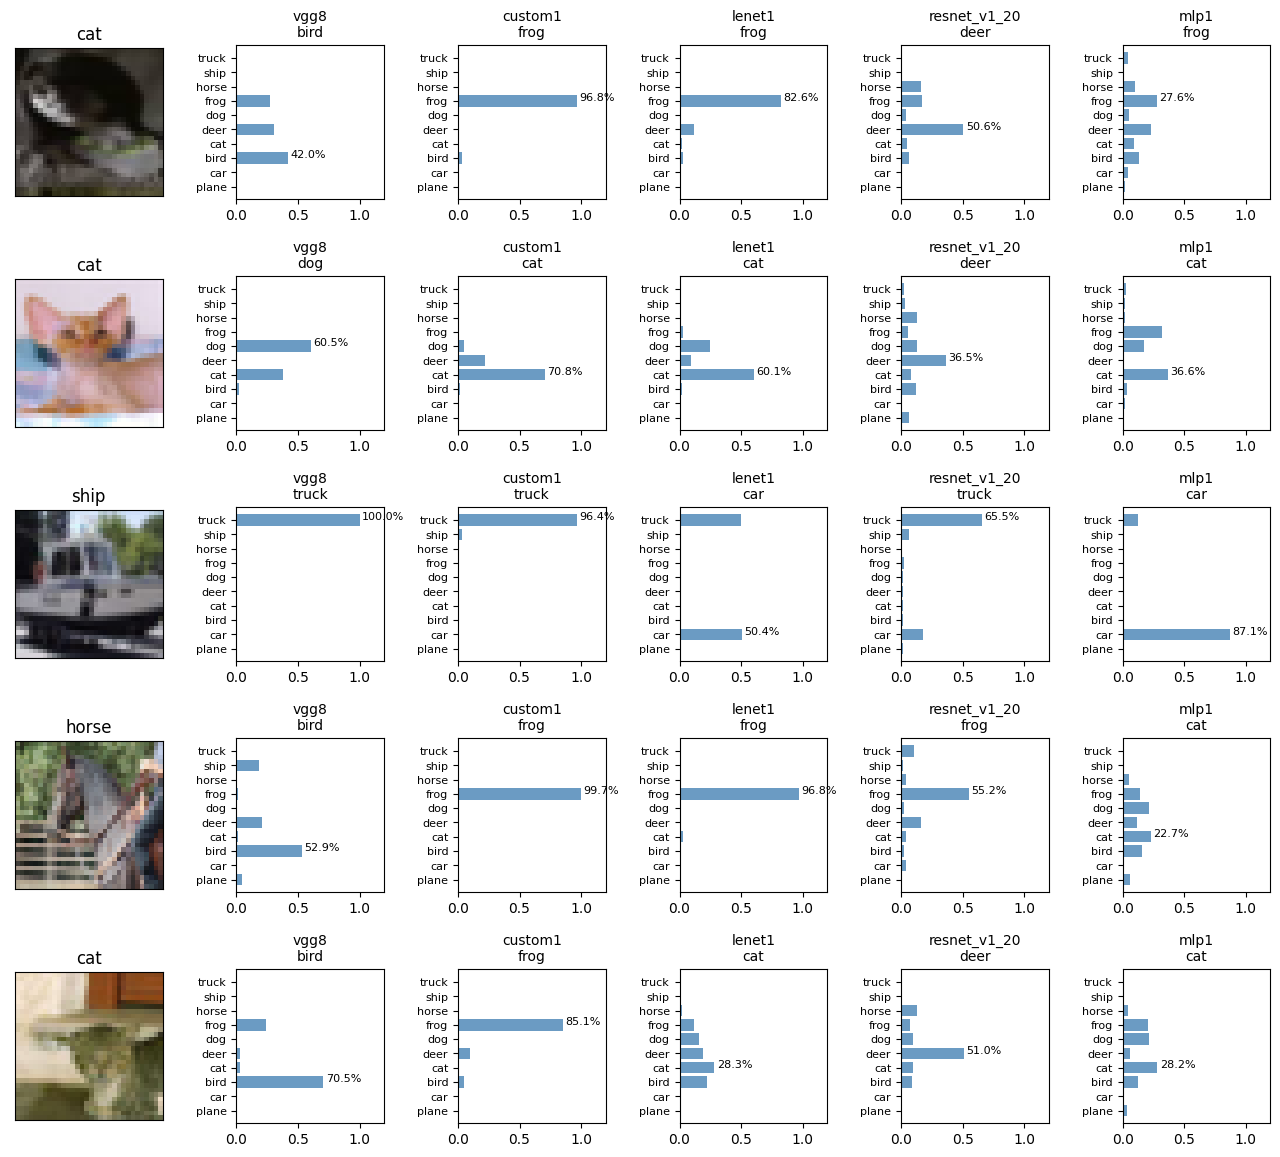

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_1000.ipynb        1672906       579.0   
2       custom1  cifar10_0808_count_1000.ipynb          73738       357.5   
3        lenet1  cifar10_0808_count_1000.ipynb          83170       330.2   
4  resnet_v1_20  cifar10_0808_count_1000.ipynb         273066        21.6   
5          mlp1  cifar10_0808_count_1000.ipynb         394634       197.3   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 13:05      0.0429     1.0663          0.9883         0.7814   
2  2022-08-09 12:55      0.1258     1.1030          0.9688         0.6856   
3  2022-08-09 12:48      0.2686     1.2903          0.9230         0.6077   
4  2022-08-09 05:45      1.6813     1.7428          0.4237         0.4041   
5  2022-08-09 12:42      1.4287     1.7135          0.4881         0.3977   

   train_auc  test_auc  
1     0.9998    0.9701  
2     0.9994    0.9503  
3     0.9968    0.9236  
4     0.8770    0.8637  
5     0.8814    0.8221

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2022-08-09 13:05:51,545: INFO: learning_rate=0.001
2022-08-09 13:05:51,546: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-09 13:05:51,552: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization_

                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_15 (BatchN  (None, 16, 16, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (Dense)                (None, 10)           650         ['flatten_4[0][0]']              
                                                                                                  
Total para

2022-08-09 13:05:51,670: INFO: model_params.resnet_v1_20.epochs=80
2022-08-09 13:05:51,671: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20, monitor=val_accuracy)
2022-08-09 13:05:51,672: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2022-08-09 13:05:51,672: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-09 13:05:51,673: INFO: use LearningRateScheduler()
2022-08-09 13:05:51,673: INFO: steps_per_epoch=312
2022-08-09 13:05:51,674: INFO: start training
2022-08-09 13:05:51,675: INFO: use_class_weight=False


Epoch 1/80
311/312 [============================>.] - ETA: 0s - loss: 1.8794 - accuracy: 0.3709

2022-08-09 13:06:08,952: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


2022-08-09 13:06:11,765: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


312/312 [==============================] - 20s 54ms/step - loss: 1.8791 - accuracy: 0.3711 - val_loss: 2.1592 - val_accuracy: 0.3282 - lr: 0.0010
Epoch 2/80
311/312 [============================>.] - ETA: 0s - loss: 1.5132 - accuracy: 0.5048

2022-08-09 13:06:25,239: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


2022-08-09 13:06:28,046: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


312/312 [==============================] - 16s 52ms/step - loss: 1.5134 - accuracy: 0.5045 - val_loss: 1.7146 - val_accuracy: 0.4469 - lr: 0.0010
Epoch 3/80
309/312 [============================>.] - ETA: 0s - loss: 1.3144 - accuracy: 0.5855

2022-08-09 13:06:41,551: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


2022-08-09 13:06:44,368: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


312/312 [==============================] - 16s 52ms/step - loss: 1.3131 - accuracy: 0.5858 - val_loss: 1.7577 - val_accuracy: 0.4510 - lr: 0.0010
Epoch 4/80
312/312 [==============================] - ETA: 0s - loss: 1.1518 - accuracy: 0.6486

2022-08-09 13:06:57,861: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


2022-08-09 13:07:00,686: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


312/312 [==============================] - 16s 52ms/step - loss: 1.1518 - accuracy: 0.6486 - val_loss: 1.7755 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 5/80
312/312 [==============================] - 7s 21ms/step - loss: 1.0008 - accuracy: 0.7042 - val_loss: 2.2708 - val_accuracy: 0.4100 - lr: 0.0010
Epoch 6/80
312/312 [==============================] - 7s 21ms/step - loss: 0.8720 - accuracy: 0.7537 - val_loss: 2.6951 - val_accuracy: 0.3772 - lr: 0.0010
Epoch 7/80
312/312 [==============================] - 7s 21ms/step - loss: 0.7741 - accuracy: 0.7936 - val_loss: 2.2243 - val_accuracy: 0.4724 - lr: 0.0010
Epoch 8/80
312/312 [==============================] - 7s 21ms/step - loss: 0.6758 - accuracy: 0.8316 - val_loss: 2.9086 - val_accuracy: 0.4342 - lr: 0.0010
Epoch 9/80
312/312 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.8590

2022-08-09 13:07:40,874: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


2022-08-09 13:07:43,687: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


312/312 [==============================] - 16s 52ms/step - loss: 0.6019 - accuracy: 0.8590 - val_loss: 2.2579 - val_accuracy: 0.5075 - lr: 0.0010
Epoch 10/80
312/312 [==============================] - 7s 21ms/step - loss: 0.5142 - accuracy: 0.8926 - val_loss: 2.7582 - val_accuracy: 0.4669 - lr: 0.0010
Epoch 11/80
312/312 [==============================] - 7s 21ms/step - loss: 0.4870 - accuracy: 0.9037 - val_loss: 2.6250 - val_accuracy: 0.5056 - lr: 0.0010
Epoch 12/80
312/312 [==============================] - 7s 22ms/step - loss: 0.4425 - accuracy: 0.9209 - val_loss: 2.6930 - val_accuracy: 0.4839 - lr: 0.0010
Epoch 13/80
312/312 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.9330

2022-08-09 13:08:17,183: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


2022-08-09 13:08:19,970: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


312/312 [==============================] - 16s 52ms/step - loss: 0.4105 - accuracy: 0.9330 - val_loss: 2.2969 - val_accuracy: 0.5184 - lr: 0.0010
Epoch 14/80
312/312 [==============================] - 7s 22ms/step - loss: 0.4036 - accuracy: 0.9374 - val_loss: 4.0770 - val_accuracy: 0.4095 - lr: 0.0010
Epoch 15/80
312/312 [==============================] - 7s 22ms/step - loss: 0.3867 - accuracy: 0.9399 - val_loss: 4.0119 - val_accuracy: 0.4207 - lr: 0.0010
Epoch 16/80
312/312 [==============================] - 7s 21ms/step - loss: 0.3814 - accuracy: 0.9457 - val_loss: 3.6588 - val_accuracy: 0.4458 - lr: 0.0010
Epoch 17/80
312/312 [==============================] - ETA: 0s - loss: 0.3582 - accuracy: 0.9545
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
312/312 [==============================] - 7s 21ms/step - loss: 0.3582 - accuracy: 0.9545 - val_loss: 3.1056 - val_accuracy: 0.4923 - lr: 3.1623e-04
Epoch 00018: Still keep learning rate 0.0003162 instead of 

2022-08-09 13:09:00,150: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


2022-08-09 13:09:03,241: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


312/312 [==============================] - 17s 53ms/step - loss: 0.2980 - accuracy: 0.9772 - val_loss: 2.1861 - val_accuracy: 0.5855 - lr: 3.1623e-04
Epoch 00019: Still keep learning rate 0.0003162 instead of 0.001
Epoch 19/80
311/312 [============================>.] - ETA: 0s - loss: 0.2359 - accuracy: 0.9997

2022-08-09 13:09:16,178: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


2022-08-09 13:09:19,468: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


312/312 [==============================] - 16s 52ms/step - loss: 0.2359 - accuracy: 0.9997 - val_loss: 2.0240 - val_accuracy: 0.6095 - lr: 3.1623e-04
Epoch 00020: Still keep learning rate 0.0003162 instead of 0.001
Epoch 20/80
310/312 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 1.0000

2022-08-09 13:09:32,522: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


2022-08-09 13:09:35,768: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20/assets


312/312 [==============================] - 16s 52ms/step - loss: 0.2263 - accuracy: 1.0000 - val_loss: 2.0426 - val_accuracy: 0.6119 - lr: 3.1623e-04
Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/80
312/312 [==============================] - 7s 21ms/step - loss: 0.2221 - accuracy: 1.0000 - val_loss: 2.0652 - val_accuracy: 0.6103 - lr: 3.1623e-04
Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/80
312/312 [==============================] - 7s 22ms/step - loss: 0.2184 - accuracy: 1.0000 - val_loss: 2.0847 - val_accuracy: 0.6099 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/80
312/312 [==============================] - 7s 22ms/step - loss: 0.2145 - accuracy: 1.0000 - val_loss: 2.1014 - val_accuracy: 0.6094 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/80
312/312 [==============================] - 7s 22ms/step - loss: 0.2103 - accuracy: 1.0000 - val

312/312 [==============================] - 7s 21ms/step - loss: 0.2835 - accuracy: 0.9618 - val_loss: 2.6495 - val_accuracy: 0.5647 - lr: 0.0010
Epoch 59/80
312/312 [==============================] - 7s 21ms/step - loss: 0.2887 - accuracy: 0.9597 - val_loss: 3.0152 - val_accuracy: 0.5031 - lr: 0.0010
Epoch 60/80
312/312 [==============================] - 7s 22ms/step - loss: 0.2851 - accuracy: 0.9633 - val_loss: 2.3876 - val_accuracy: 0.5809 - lr: 0.0010
Epoch 60: early stopping


2022-08-09 13:14:03,595: INFO: finish training [elapsed time: 491.92 seconds]


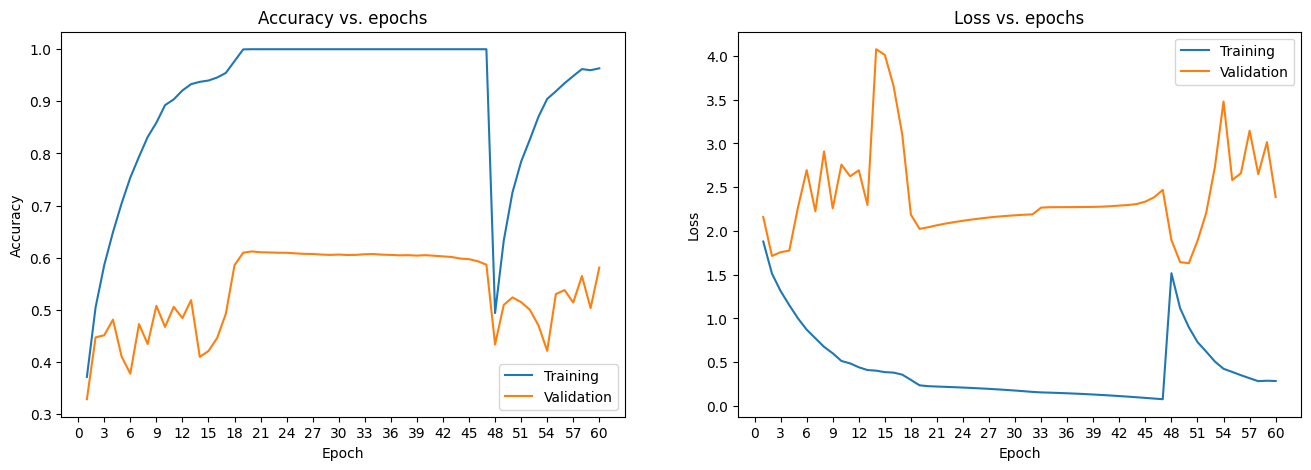

2022-08-09 13:14:04,028: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-09 13:14:19,400: INFO: test loss:2.0426
2022-08-09 13:14:19,401: INFO: test accuracy:0.6119
2022-08-09 13:14:19,405: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 13:14:19,407: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 13:14:19,407: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:14:19,409: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:14:19,409: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_10

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-09 13:14:20,874: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator


313/313 [==============================] - 1s 3ms/step


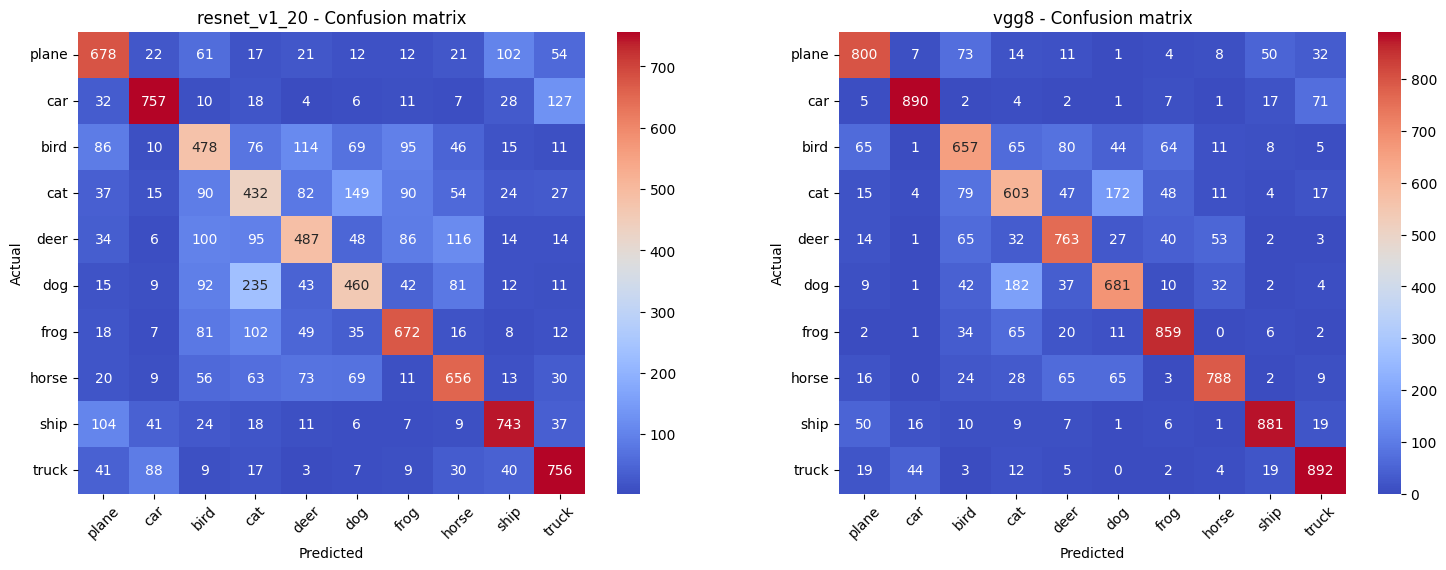

2022-08-09 13:14:27,747: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/vgg8


----------------------------------------sample analysis----------------------------------------


2022-08-09 13:14:29,250: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:14:29,264: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/custom1
2022-08-09 13:14:30,180: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:14:30,185: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/lenet1
2022-08-09 13:14:30,970: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/default.generator
2022-08-09 13:14:30,974: INFO: loading model from /tf/eipi10/xuxiangwen.gi

1/1 [==============================] - 0s 9ms/step


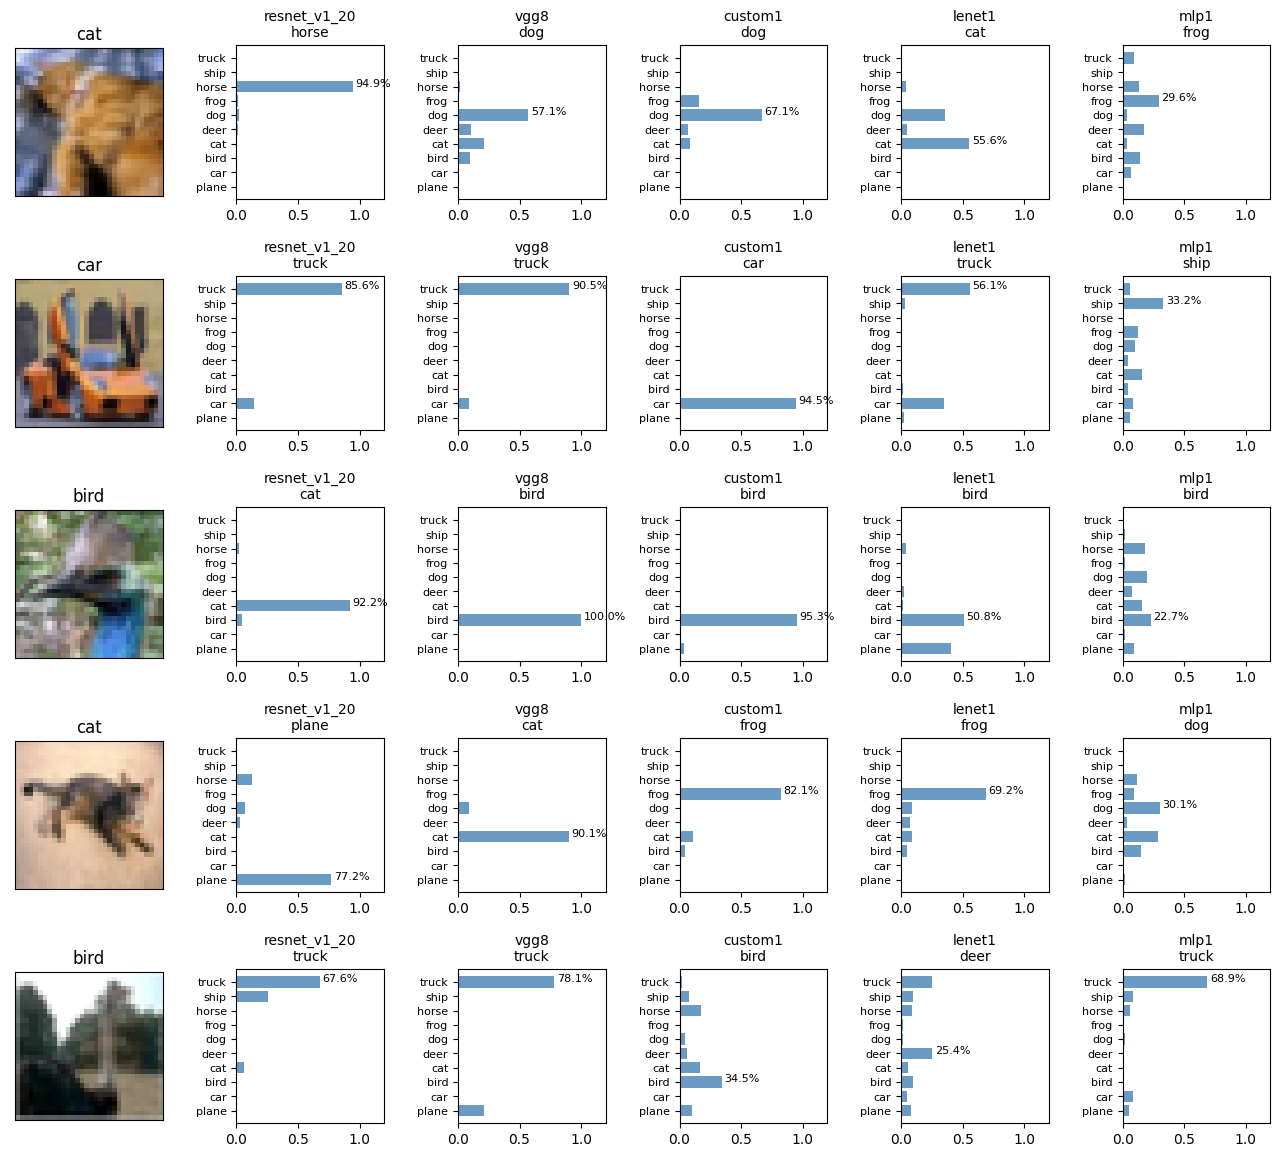

----------------------------------------models----------------------------------------


model_name                   program_name  weight_number  train_time  \
1          vgg8  cifar10_0808_count_1000.ipynb        1672906       579.0   
2       custom1  cifar10_0808_count_1000.ipynb          73738       357.5   
3  resnet_v1_20  cifar10_0808_count_1000.ipynb         273066       491.9   
4        lenet1  cifar10_0808_count_1000.ipynb          83170       330.2   
5          mlp1  cifar10_0808_count_1000.ipynb         394634       197.3   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-09 13:05      0.0429     1.0663          0.9883         0.7814   
2  2022-08-09 12:55      0.1258     1.1030          0.9688         0.6856   
3  2022-08-09 13:14      0.2343     2.0426          0.9983         0.6119   
4  2022-08-09 12:48      0.2686     1.2903          0.9230         0.6077   
5  2022-08-09 12:42      1.4287     1.7135          0.4881         0.3977   

   train_auc  test_auc  
1     0.9998    0.9701  
2     0.9994    0.9503  
3     1.0000    0.9207  
4     0.9968    0.9236  
5     0.8814    0.8221

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [25]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-09 13:14:38,626: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-09 13:14:38,628: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2022-08-09 13:14:38,629: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_1000/results.json
2022-08-09 13:14:38,630: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_2000/results.json
2022-08-09 13:14:38,631: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/results.json
2022-08-09 13:14:38,633: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflo

model_name                   program_name  weight_number  train_time  \
1           vgg8        cifar10_0808_p100.ipynb        1672906      2759.0   
2           vgg8        cifar10_0721_p100.ipynb        1672906      2195.2   
3           vgg8  cifar10_0808_count_5000.ipynb        1672906      1973.9   
4           vgg8  cifar10_0808_count_2000.ipynb        1672906      1399.2   
5   resnet_v1_20        cifar10_0808_p100.ipynb         273066      3631.9   
6   resnet_v1_20  cifar10_0808_count_5000.ipynb         273066      2984.0   
7   resnet_v1_20        cifar10_0721_p100.ipynb         273066      4091.3   
8        custom1        cifar10_0808_p100.ipynb          73738       849.4   
9        custom1  cifar10_0808_count_5000.ipynb          73738       836.9   
10       custom1        cifar10_0721_p100.ipynb          73738      1190.8   

         create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1   2022-08-09 10:18      0.0017     0.5896          0.9997         0.8968   
2   2021-12-02 08:49      0.0029     0.5959          0.9995         0.8921   
3   2022-08-09 07:07      0.0044     0.5588          0.9991         0.8873   
4   2022-08-09 10:22      0.0064     0.8481          0.9987         0.8418   
5   2022-08-09 11:19      0.1058     1.3800          0.9979         0.8262   
6   2022-08-09 07:58      0.2096     1.1902          0.9986         0.8252   
7   2021-12-02 09:58      0.1180     1.3054          0.9985         0.8197   
8   2022-08-09 09:31      0.3383     0.5942          0.8858         0.8009   
9   2022-08-09 06:34      0.3235     0.6073          0.8893         0.7981   
10  2021-12-02 08:12      0.3420     0.6094          0.8832         0.7947   

    train_auc  test_auc  
1      1.0000    0.9922  
2      1.0000    0.9920  
3      1.0000    0.9919  
4      1.0000    0.9838  
5      1.0000    0.9796  
6      1.0000    0.9810  
7      1.0000    0.9791  
8      0.9926    0.9778  
9      0.9934    0.9776  
10     0.9929    0.9776

In [26]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-09 13:14:38,709: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/vgg8
2022-08-09 13:14:40,209: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_p100/default.generator
2022-08-09 13:14:40,215: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2022-08-09 13:14:41,835: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2022-08-09 13:14:41,841: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0808_count_5000/vgg8
2022-08-09 13:14:43,732: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_c

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

1/1 [==============================] - 0s 13ms/step


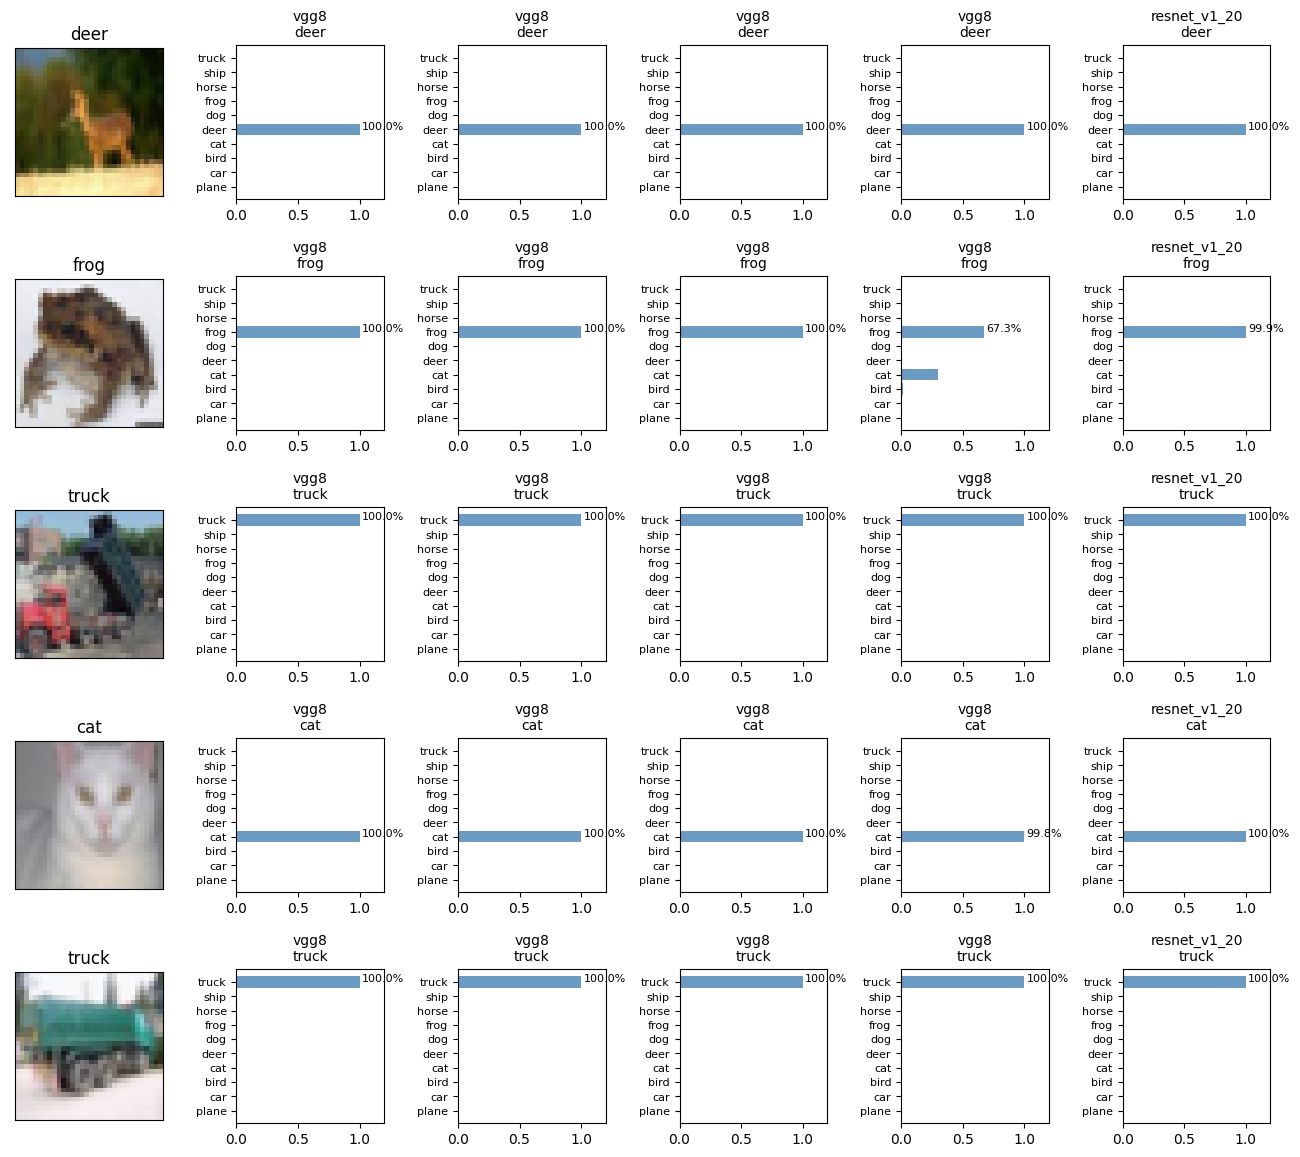

In [27]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 13ms/step


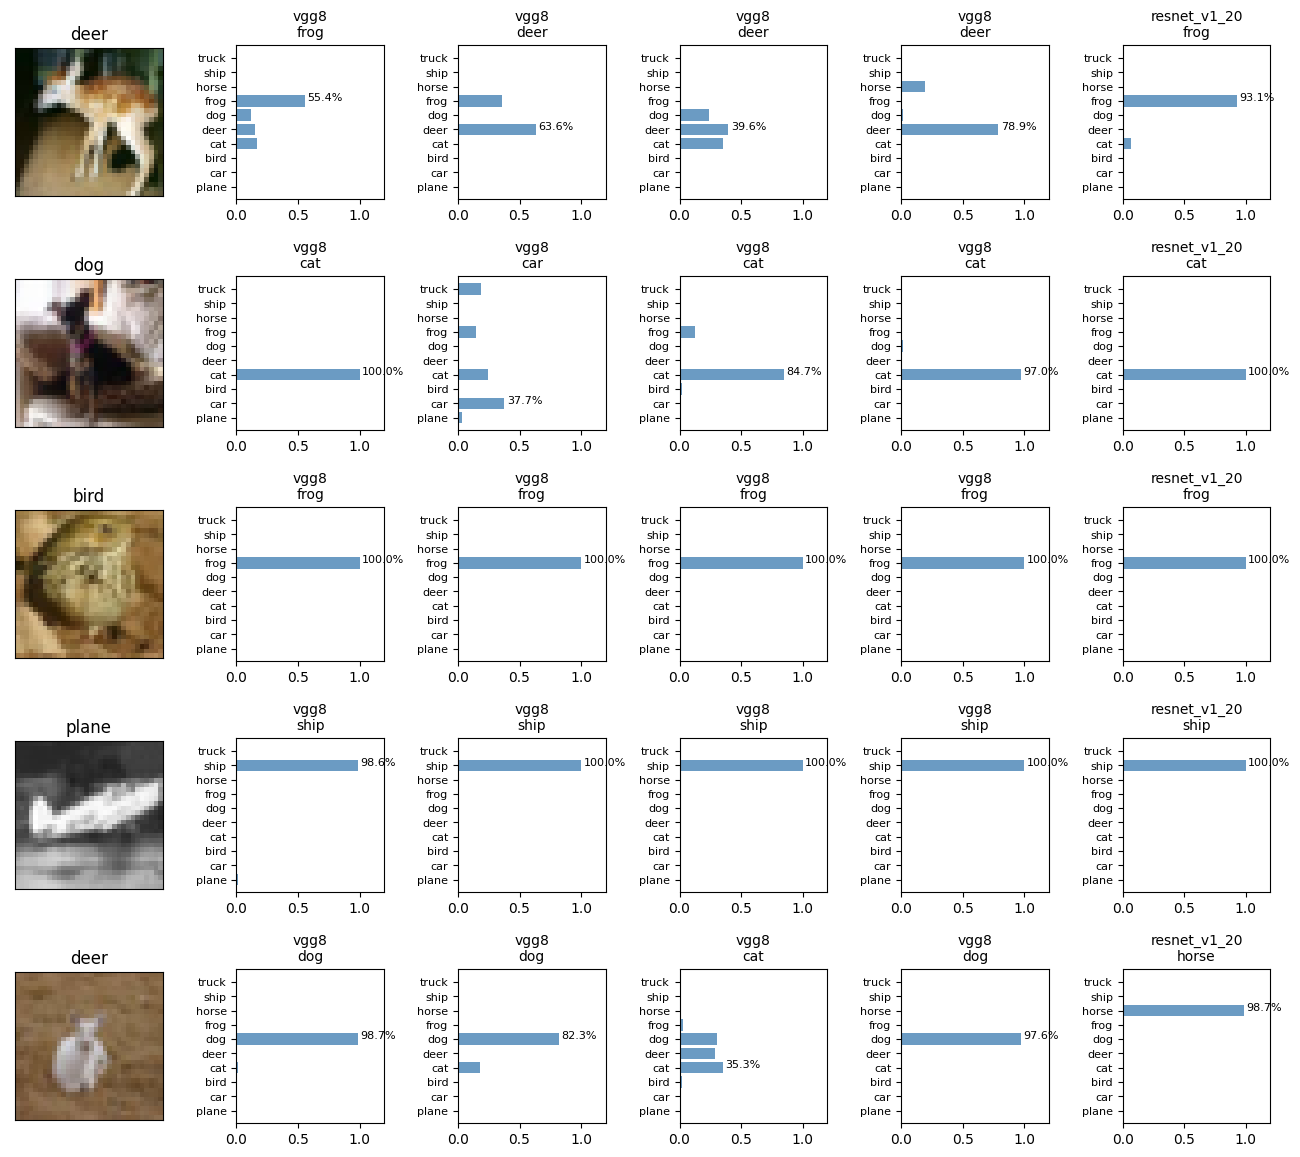

In [28]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [29]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.5896327495574951, 'accuracy': 0.8967999815940857, 'mae': 25.367116928100586}
313/313 [==============================] - 1s 3ms/step
(10000, 10)


In [30]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 1s 3ms/step


precision  recall        f1
plane   0.904245   0.916  0.910084
car     0.944334   0.950  0.947159
bird    0.872802   0.844  0.858160
cat     0.819549   0.763  0.790264
deer    0.889655   0.903  0.896278
dog     0.824832   0.857  0.840608
frog    0.897901   0.941  0.918945
horse   0.941358   0.915  0.927992
ship    0.943775   0.940  0.941884
truck   0.926950   0.939  0.932936

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9042    0.9160    0.9101      1000
         car     0.9443    0.9500    0.9472      1000
        bird     0.8728    0.8440    0.8582      1000
         cat     0.8195    0.7630    0.7903      1000
        deer     0.8897    0.9030    0.8963      1000
         dog     0.8248    0.8570    0.8406      1000
        frog     0.8979    0.9410    0.9189      1000
       horse     0.9414    0.9150    0.9280      1000
        ship     0.9438    0.9400    0.9419      1000
       truck     0.9269    0.9390    0.9329      1000

    accuracy                         0.8968     10000
   macro avg     0.8965    0.8968    0.8964     10000
weighted avg     0.8965    0.8968    0.8964     10000



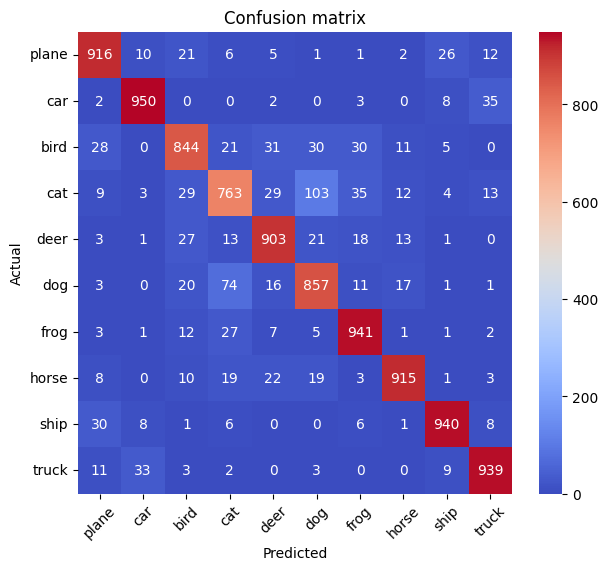

In [31]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [32]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset